In [1]:
from os import sys
sys.path.append("/meshAfterParty/")

In [2]:
import skeleton_utils as sk
import soma_extraction_utils as sm
import trimesh_utils as tu
import trimesh
import numpy_utils as nu
import numpy as np
from importlib import reload
import networkx as nx
import time
import compartment_utils as cu
import networkx_utils as xu
import matplotlib_utils as mu
import neuron_utils as nru

#importing at the bottom so don't get any conflicts
import itertools
from tqdm_utils import tqdm

#for meshparty preprocessing
import meshparty_skeletonize as m_sk
import general_utils as gu
import compartment_utils as cu
from meshparty import trimesh_io
from copy import deepcopy


from neuron_utils import *


WARNING - 2020-11-18 01:45:02,955 - trimesh_repair - Need to pip install annotationframeworkclient to repair mesh with pychunkedgraph
WARNING - 2020-11-18 01:45:02,957 - trimesh_io - Need to pip install annotationframeworkclient to use dataset_name parameters
INFO - 2020-11-18 01:45:02,964 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2020-11-18 01:45:02,965 - settings - Setting database.user to celiib
INFO - 2020-11-18 01:45:02,965 - settings - Setting database.password to newceliipass


# Downloading the Neuron

In [5]:
import datajoint_utils as du
import neuron_visualizations as nviz
du = reload(du)

INFO - 2020-11-18 01:46:34,343 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2020-11-18 01:46:34,344 - settings - Setting database.user to celiib
INFO - 2020-11-18 01:46:34,346 - settings - Setting database.password to newceliipass


In [6]:
segment_id = 864691135612275396

print(f"curr_segment_id = {segment_id}")
current_neuron = du.fetch_segment_id_mesh(segment_id)
nviz.plot_objects(current_neuron)

INFO - 2020-11-18 01:46:36,061 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2020-11-18 01:46:36,062 - settings - Setting enable_python_native_blobs to True
INFO - 2020-11-18 01:46:36,078 - connection - Connected celiib@at-database.ad.bcm.edu:3306


curr_segment_id = 864691135612275396
Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2020-11-18 01:46:36,259 - settings - Setting enable_python_native_blobs to True
/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


In [8]:
description="double_soma_with_large_apical"

In [9]:
#predefined arguments for the Neuron constructor

decomposition_type="meshafterparty"
mesh_correspondence="meshparty" #meshafterparty_adaptive
distance_by_mesh_center=True #how the distance is calculated for mesh correspondence
meshparty_segment_size = 100
meshparty_n_surface_downsampling = 2
meshparty_adaptive_correspondence_after_creation=False
suppress_preprocessing_print=True
computed_attribute_dict=None
#somas = None
branch_skeleton_data=None
combine_close_skeleton_nodes = True
combine_close_skeleton_nodes_threshold=700
ignore_warnings=True
suppress_output=False
calculate_spines=True
widths_to_calculate=["no_spine_median_mesh_center"]
fill_hole_size=2000

In [10]:
#arguments for the preprocess neuron
mesh = current_neuron
segment_id=segment_id
description=description

sig_th_initial_split=15 #for significant splitting meshes in the intial mesh split
limb_threshold = 2000 #the mesh faces threshold for a mesh to be qualified as a limb (otherwise too small)
filter_end_node_length=4001 #used in cleaning the skeleton during skeletonizations
return_no_somas = False

decomposition_type=decomposition_type
mesh_correspondence=mesh_correspondence
distance_by_mesh_center=distance_by_mesh_center
meshparty_segment_size =meshparty_segment_size
meshparty_n_surface_downsampling = meshparty_n_surface_downsampling
somas=None
branch_skeleton_data=branch_skeleton_data
combine_close_skeleton_nodes = combine_close_skeleton_nodes
combine_close_skeleton_nodes_threshold=combine_close_skeleton_nodes_threshold

if "meshafterparty" in decomposition_type.lower():
    use_meshafterparty = True
else:
    use_meshafterparty = False

# Setting up the metadata

In [11]:
import meshlab
meshlab = reload(meshlab)
import numpy as np
random_port = np.random.randint(100,10000)
meshlab.set_meshlab_port(random_port)
print(f"The random port chosen was = {meshlab.Meshlab.unique_port}")

The random port chosen was = 8210


In [12]:
whole_processing_tiempo = time.time()


"""
Purpose: To process the mesh into a format that can be loaded into the neuron class
and used for higher order processing (how to visualize is included)

"""
if description is None:
    description = "no_description"
if segment_id is None:
    #pick a random segment id
    segment_id = np.random.randint(100000000)
    print(f"picking a random 7 digit segment id: {segment_id}")
    description += "_random_id"


if mesh is None:
    if current_mesh_file is None:
        raise Exception("No mesh or mesh_file file were given")
    else:
        current_neuron = trimesh.load_mesh(current_mesh_file)
else:
    print("Mesh was not none")
    current_neuron = mesh

Mesh was not none


In [13]:
tu = reload(tu)

# -------- Phase 1: Doing Soma Detection (if Not already done) ---------- #
if somas is None:
    soma_mesh_list,run_time,total_soma_list_sdf = sm.extract_soma_center(segment_id,
                                             current_neuron.vertices,
                                             current_neuron.faces)
else:
    soma_mesh_list,run_time,total_soma_list_sdf = somas
    print(f"Using pre-computed somas: soma_mesh_list = {soma_mesh_list}")

# geting the soma centers
if len(soma_mesh_list) <= 0:
    print(f"**** No Somas Found for Mesh {segment_id} so just one mesh")
    soma_mesh_list_centers = []
    if return_no_somas:
        return_value= soma_mesh_list_centers
    raise Exception("Processing of No Somas is not yet implemented yet")
else:
    #compute the soma centers
    print(f"Soma List = {soma_mesh_list}")

    soma_mesh_list_centers = sm.find_soma_centroids(soma_mesh_list)
    print(f"soma_mesh_list_centers = {soma_mesh_list_centers}")


Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 15000.0 
large_mesh_threshold_inner = 10000.0 
soma_size_threshold = 937.5 
soma_size_threshold_max = 12000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/864691135612275396/neuron_864691135612275396.off -o /notebooks/Platinum_Decomp_Fusion/864691135612275396/neuron_864691135612275396_decimated.off -s /notebooks/Platinum_Decomp_Fusion/864691135612275396/decimation_meshlab_25432968.mls
Total found significant pieces before Poisson = [<trimesh.Trimesh(vertices.shape=(135549, 3), faces.shape=(268703, 3))>]
----- working on large mesh #0: <trimesh.Trimesh(vertices.shape=(135549, 3), faces.shape=(268703, 3))>
remove_inside_pieces requested 
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_48525.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_

done exporting decimated mesh: neuron_864691135612275396_decimated_largest_piece_poisson_largest_inner.off
1) Starting: Mesh importing and Pymesh fix
loading mesh from vertices and triangles array
1) Finished: Mesh importing and Pymesh fix: 0.0002899169921875
2) Staring: Generating CGAL segmentation for neuron
Done writing OFF file

Starting CGAL segmentation
Right before cgal segmentation, clusters = 3, smoothness = 0.2, path_and_filename = /notebooks/Platinum_Decomp_Fusion/temp/86469113561227539601_fixed 
1
Finished CGAL segmentation algorithm: 0.5373692512512207
2) Finished: Generating CGAL segmentation for neuron: 0.6244008541107178
3) Staring: Generating Graph Structure and Identifying Soma using soma size threshold  = 3000
my_list_keys = [0, 1, 2, 3, 4, 5, 6]
soma_index = -1
3) Finished: Generating Graph Structure and Identifying Soma: 0.0021331310272216797
Not finding the apical because soma_only option selected
6) Staring: Classifying Entire Neuron
Total Labels found = {'unsure

/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])


xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_474744.off -o /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_474744_poisson.off -s /notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_118350.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_474744.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_474744_poisson.off
mesh.is_watertight = True
/notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_118350.mls is being deleted....
Inside sphere validater: ratio_val = 3.6352932094910124
Performing Soma Mesh Backtracking to original mesh
# total split meshes = 18
viable_meshes = [0]
There were 17 pieces found after size threshold
# of soma containing seperate meshes = 1
meshes with somas = {0: [0]}


----Working on soma-containing mesh piece 0----
current_soma_mesh_list = [<trimesh.Trimesh(vertices.shape=(1164, 3), faces.shape=(2273, 3))>]


meshes_split = [<trimesh.Trimesh(vertices.shape=(3073, 3), faces.shape=(5949, 3))>, <trimesh.Trimesh(vertices.shape=(83, 3), faces.shape=(140, 3))>]
meshes_split_sdf = [0.678388  0.0573567]
removing mesh interior before segmentation
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_93937.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_93937_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_775990.mls


/meshAfterParty/trimesh_utils.py:996: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))



---- meshlab output -----
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
Current Plugins Dir is: /meshlab/src/distrib/plugins 
Error While parsing the XML filter plugin descriptors: We are trying to load a xml file that does not correspond to any dll or javascript code; please delete all the spurious xml files
Error While parsing the XML filter plugin descriptors: We are trying to load a xml file that does not correspond to any dll or javascript code; please delete all the spurious xml files
Opening a file with extention off
FilterScript
Reading filter with name Remove Duplicate Vertices
Reading filter with name Remove Faces from Non Manifold Edges
Reading filter with name Close Holes
    Reading Param with name MaxHoleSize : RichInt
    Reading Param with name Selected : RichBool
    Reading Param with name NewFaceSelected : RichBool
    Reading Param with name SelfIntersection : RichBool
Loading Plugins:
Total 104 filtering actions
Total 1 io plugins
Mesh


meshes_split = [<trimesh.Trimesh(vertices.shape=(3887, 3), faces.shape=(7549, 3))>, <trimesh.Trimesh(vertices.shape=(244, 3), faces.shape=(430, 3))>, <trimesh.Trimesh(vertices.shape=(48, 3), faces.shape=(88, 3))>, <trimesh.Trimesh(vertices.shape=(16, 3), faces.shape=(26, 3))>, <trimesh.Trimesh(vertices.shape=(5, 3), faces.shape=(3, 3))>]
meshes_split_sdf = [0.849137   0.393761   0.00865181 0.00373345 0.130333  ]
Soma List = [<trimesh.Trimesh(vertices.shape=(3073, 3), faces.shape=(5949, 3))>, <trimesh.Trimesh(vertices.shape=(3887, 3), faces.shape=(7549, 3))>]
soma_mesh_list_centers = [array([917309.54835666, 996751.17295802, 918815.01324439]), array([988192.73228711, 991952.13771546, 911378.92876254])]


In [14]:
#--- Phase 2: getting the soma submeshes that are connected to each soma and identifiying those that aren't 
# ------------------ (and eliminating any mesh pieces inside the soma) ------------------------

# -------- 11/13 Addition: Will remove the inside nucleus --------- #
main_mesh_total,inside_nucleus_pieces = tu.remove_mesh_interior(current_neuron,return_removed_pieces=True)


#finding the mesh pieces that contain the soma
#splitting the current neuron into distinct pieces
split_meshes = tu.split_significant_pieces(
                            main_mesh_total,
                            significance_threshold=sig_th_initial_split,
                            print_flag=False)

print(f"# total split meshes = {len(split_meshes)}")


#returns the index of the split_meshes index that contains each soma    
containing_mesh_indices = sm.find_soma_centroid_containing_meshes(soma_mesh_list,
                                        split_meshes)

# filtering away any of the inside floating pieces: 
non_soma_touching_meshes = [m for i,m in enumerate(split_meshes)
                 if i not in list(containing_mesh_indices.values())]


#Adding the step that will filter away any pieces that are inside the soma
if len(non_soma_touching_meshes) > 0 and len(soma_mesh_list) > 0:
    """
    *** want to save these pieces that are inside of the soma***
    """

    non_soma_touching_meshes,inside_pieces = sm.filter_away_inside_soma_pieces(soma_mesh_list,non_soma_touching_meshes,
                                    significance_threshold=sig_th_initial_split,
                                    return_inside_pieces = True)

else:
    non_soma_touching_meshes = []
    inside_pieces=[]

#adding in the nuclei center to the inside pieces
inside_pieces += inside_nucleus_pieces


split_meshes # the meshes of the original mesh
containing_mesh_indices #the mapping of each soma centroid to the correct split mesh
soma_containing_meshes = sm.grouping_containing_mesh_indices(containing_mesh_indices)

soma_touching_meshes = [split_meshes[k] for k in soma_containing_meshes.keys()]


#     print(f"# of non soma touching seperate meshes = {len(non_soma_touching_meshes)}")
#     print(f"# of inside pieces = {len(inside_pieces)}")
print(f"\n-----Before filtering away multiple disconneted soma pieces-----")
print(f"# of soma containing seperate meshes = {len(soma_touching_meshes)}")
print(f"meshes with somas = {soma_containing_meshes}")

xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_61307.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_61307_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_210685.mls

---- meshlab output -----
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
Current Plugins Dir is: /meshlab/src/distrib/plugins 
Error While parsing the XML filter plugin descriptors: We are trying to load a xml file that does not correspond to any dll or javascript code; please delete all the spurious xml files
Error While parsing the XML filter plugin descriptors: We are trying to load a xml file that does not correspond to any dll or javascript code; please delete all the spurious xml files
Opening a file with extention off
FilterScript
Reading filter with name Remove Duplicate Vertices
Reading filter with name Remove Faces from Non Manifold Edges
Reading filter with name Close Holes
    Reading Param with 

# Extra Part that will only keep the largest piece that has a soma

In [15]:
# ------ 11/15 Addition: Part 2.b 

"""
Pseudocode: 
1) Get the largest of the meshes with a soma (largest in soma_touching_meshes)
2) Save all other meshes not the largest in 
3) Overwrite the following variables:
    soma_mesh_list
    soma_containing_meshes
    soma_touching_meshes
    total_soma_list_sdf
    

"""
#1) Get the largest of the meshes with a soma (largest in soma_touching_meshes)
soma_containing_meshes_keys = np.array(list(soma_containing_meshes.keys()))
soma_touching_meshes = np.array([split_meshes[k] for k in soma_containing_meshes_keys])
largest_soma_touching_mesh_idx = soma_containing_meshes_keys[np.argmax([len(kk.faces) for kk in soma_touching_meshes])]

#2) Save all other meshes not the largest in 
not_processed_soma_containing_meshes_idx = np.setdiff1d(soma_containing_meshes_keys,[largest_soma_touching_mesh_idx])
not_processed_soma_containing_meshes = [split_meshes[k] for k in not_processed_soma_containing_meshes_idx]
print(f"Number of not_processed_soma_containing_meshes = {len(not_processed_soma_containing_meshes)}")

"""
3) Overwrite the following variables:
    soma_mesh_list
    soma_containing_meshes
    soma_touching_meshes
    total_soma_list_sdf
    
"""

somas_idx_to_process = soma_containing_meshes[largest_soma_touching_mesh_idx]
soma_mesh_list = [soma_mesh_list[k] for k in somas_idx_to_process]

soma_containing_meshes = {largest_soma_touching_mesh_idx:list(np.arange(0,len(soma_mesh_list)))}

soma_touching_meshes = [split_meshes[largest_soma_touching_mesh_idx]]

total_soma_list_sdf = total_soma_list_sdf[somas_idx_to_process]

print(f"\n-----After filtering away multiple disconneted soma pieces-----")
print(f"# of soma containing seperate meshes = {len(soma_touching_meshes)}")
print(f"meshes with somas = {soma_containing_meshes}")

Number of not_processed_soma_containing_meshes = 0

-----After filtering away multiple disconneted soma pieces-----
# of soma containing seperate meshes = 1
meshes with somas = {0: [0, 1]}


In [16]:

#--- Phase 3:  Soma Extraction was great (but it wasn't the original soma faces), so now need to get the original soma faces and the original non-soma faces of original pieces

"""
for each soma touching mesh get the following:
1) original soma meshes
2) significant mesh pieces touching these somas
3) The soma connectivity to each of the significant mesh pieces
-- later will just translate the 


Process: 

1) Final all soma faces (through soma extraction and then soma original faces function)
2) Subtact all soma faces from original mesh
3) Find all significant mesh pieces
4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all
   the available somas
Conclusion: Will have connectivity map


"""

soma_touching_mesh_data = dict()

for z,(mesh_idx, soma_idxes) in enumerate(soma_containing_meshes.items()):
    soma_touching_mesh_data[z] = dict()
    print(f"\n\n----Working on soma-containing mesh piece {z}----")

    #1) Final all soma faces (through soma extraction and then soma original faces function)
    current_mesh = split_meshes[mesh_idx]

    current_soma_mesh_list = [soma_mesh_list[k] for k in soma_idxes]

    current_time = time.time()
    mesh_pieces_without_soma = sm.subtract_soma(current_soma_mesh_list,current_mesh,
                                                significance_threshold=250)
    print(f"Total time for Subtract Soam = {time.time() - current_time}")
    current_time = time.time()

    mesh_pieces_without_soma_stacked = tu.combine_meshes(mesh_pieces_without_soma)

    # find the original soma faces of mesh
    soma_faces = tu.original_mesh_faces_map(current_mesh,mesh_pieces_without_soma_stacked,matching=False)
    print(f"Total time for Original_mesh_faces_map for mesh_pieces without soma= {time.time() - current_time}")
    current_time = time.time()
    soma_meshes = current_mesh.submesh([soma_faces],append=True,repair=False)

    # finding the non-soma original faces
    non_soma_faces = tu.original_mesh_faces_map(current_mesh,soma_meshes,matching=False)
    non_soma_stacked_mesh = current_mesh.submesh([non_soma_faces],append=True,repair=False)

    print(f"Total time for Original_mesh_faces_map for somas= {time.time() - current_time}")
    current_time = time.time()

    # 3) Find all significant mesh pieces
    sig_non_soma_pieces,insignificant_limbs = tu.split_significant_pieces(non_soma_stacked_mesh,significance_threshold=limb_threshold,
                                                     return_insignificant_pieces=True)

    print(f"Total time for sig_non_soma_pieces= {time.time() - current_time}")
    current_time = time.time()

    soma_touching_mesh_data[z]["branch_meshes"] = sig_non_soma_pieces

    #4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all the available somas
    # get all the seperate mesh faces

    #How to seperate the mesh faces
    seperate_soma_meshes,soma_face_components = tu.split(soma_meshes,only_watertight=False)
    #take the top largest ones depending how many were originally in the soma list
    seperate_soma_meshes = seperate_soma_meshes[:len(soma_mesh_list)]
    soma_face_components = soma_face_components[:len(soma_mesh_list)]

    soma_touching_mesh_data[z]["soma_meshes"] = seperate_soma_meshes

    print(f"Total time for split= {time.time() - current_time}")
    current_time = time.time()



    soma_to_piece_connectivity = dict()
    soma_to_piece_touching_vertices = dict()
    soma_to_piece_touching_vertices_idx = dict()
    limb_root_nodes = dict()

    m_vert_graph = tu.mesh_vertex_graph(current_mesh)

    for i,curr_soma in enumerate(seperate_soma_meshes):
        (connected_mesh_pieces,
         connected_mesh_pieces_vertices,
         connected_mesh_pieces_vertices_idx) = tu.mesh_pieces_connectivity(
                        main_mesh=current_mesh,
                        central_piece=curr_soma,
                        periphery_pieces = sig_non_soma_pieces,
                        return_vertices = True,
                        return_vertices_idx=True)
        #print(f"soma {i}: connected_mesh_pieces = {connected_mesh_pieces}")
        soma_to_piece_connectivity[i] = connected_mesh_pieces

        soma_to_piece_touching_vertices[i] = dict()
        for piece_index,piece_idx in enumerate(connected_mesh_pieces):
            limb_root_nodes[piece_idx] = connected_mesh_pieces_vertices[piece_index][0]

            """ Old way of finding vertex connected components on a mesh without trimesh function
            #find the number of touching groups and save those 
            soma_touching_graph = m_vert_graph.subgraph(connected_mesh_pieces_vertices_idx[piece_index])
            soma_con_comp = [current_mesh.vertices[np.array(list(k)).astype("int")] for k in list(nx.connected_components(soma_touching_graph))]
            soma_to_piece_touching_vertices[i][piece_idx] = soma_con_comp
            """

            soma_to_piece_touching_vertices[i][piece_idx] = tu.split_vertex_list_into_connected_components(
                                                vertex_indices_list=connected_mesh_pieces_vertices_idx[piece_index],
                                                mesh=current_mesh, 
                                                vertex_graph=m_vert_graph, 
                                                return_coordinates=True
                                               )





#         border_debug = False
#         if border_debug:
#             print(f"soma_to_piece_connectivity = {soma_to_piece_connectivity}")
#             print(f"soma_to_piece_touching_vertices = {soma_to_piece_touching_vertices}")


    print(f"Total time for mesh_pieces_connectivity= {time.time() - current_time}")

    soma_touching_mesh_data[z]["soma_to_piece_connectivity"] = soma_to_piece_connectivity

print(f"# of insignificant_limbs = {len(insignificant_limbs)} with trimesh : {insignificant_limbs}")



# Lets have an alert if there was more than one soma disconnected meshes
if len(soma_touching_mesh_data.keys()) > 1:
    raise Exception("More than 1 disconnected meshes that contain somas")

current_mesh_data = soma_touching_mesh_data
soma_containing_idx = 0

#doing inversion of the connectivity and touching vertices
piece_to_soma_touching_vertices = gu.flip_key_orders_for_dict(soma_to_piece_touching_vertices)




----Working on soma-containing mesh piece 0----

inside Soma subtraction
mesh pieces in subtact soma BEFORE the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(155254, 3), faces.shape=(309814, 3))>, <trimesh.Trimesh(vertices.shape=(95592, 3), faces.shape=(190661, 3))>, <trimesh.Trimesh(vertices.shape=(68038, 3), faces.shape=(135727, 3))>, <trimesh.Trimesh(vertices.shape=(56116, 3), faces.shape=(111760, 3))>, <trimesh.Trimesh(vertices.shape=(54962, 3), faces.shape=(109325, 3))>, <trimesh.Trimesh(vertices.shape=(36685, 3), faces.shape=(73050, 3))>, <trimesh.Trimesh(vertices.shape=(22728, 3), faces.shape=(45319, 3))>, <trimesh.Trimesh(vertices.shape=(11100, 3), faces.shape=(22153, 3))>, <trimesh.Trimesh(vertices.shape=(10667, 3), faces.shape=(21276, 3))>, <trimesh.Trimesh(vertices.shape=(136, 3), faces.shape=(264, 3))>]
There were 10 pieces found after size threshold
mesh pieces in subtact soma AFTER the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(155254, 3),

In [17]:
nviz.plot_objects(meshes=seperate_soma_meshes)

# Doing the Limb Processing

In [18]:
# import meshlab
# meshlab = reload(meshlab)
# import numpy as np
# random_port = np.random.randint(100,10000)
# meshlab.set_meshlab_port(random_port)
# print(f"The random port chosen was = {meshlab.Meshlab.unique_port}")

In [20]:
sk = reload(sk)
tu = reload(tu)
cu = reload(cu)
m_sk = reload(m_sk)
pre = reload(pre)
xu = reload(xu)
nu = reload(nu)
gu = reload(gu)




# Phase 4: Skeletonization, Mesh Correspondence,  

proper_time = time.time()

#The containers that will hold the final data for the preprocessed neuron
limb_correspondence=dict()
limb_network_stating_info = dict()

# ---------- Part A: skeletonization and mesh decomposition --------- #
skeleton_time = time.time()

for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):

    #Arguments to pass to the specific function (when working with a limb)
    soma_touching_vertices_dict = piece_to_soma_touching_vertices[curr_limb_idx]

#     if curr_limb_idx != 10:
#         continue

    curr_limb_time = time.time()
    print(f"\n\n----- Working on Proper Limb # {curr_limb_idx} ---------")

    print(f"meshparty_segment_size = {meshparty_segment_size}")
    limb_correspondence_individual,network_starting_info = pre.preprocess_limb(mesh=limb_mesh_mparty,
                   soma_touching_vertices_dict = soma_touching_vertices_dict,
                   return_concept_network = False, 
                   return_concept_network_starting_info=True,
                   width_threshold_MAP=500,
                   size_threshold_MAP=2000,
                   surface_reconstruction_size=1000,  

                   #arguments added from the big preprocessing step                                                            
                   distance_by_mesh_center=distance_by_mesh_center,
                   meshparty_segment_size=meshparty_segment_size,
                   meshparty_n_surface_downsampling = meshparty_n_surface_downsampling,

                    use_meshafterparty=use_meshafterparty,

                   )
    #Storing all of the data to be sent to 

    limb_correspondence[curr_limb_idx] = limb_correspondence_individual
    limb_network_stating_info[curr_limb_idx] = network_starting_info

print(f"Total time for Skeletonization and Mesh Correspondence = {time.time() - skeleton_time}")



# ---------- Part B: Stitching on floating pieces --------- #
print("\n\n ----- Working on Stitching ----------")

floating_stitching_time = time.time()

limb_correspondence_with_floating_pieces = pre.attach_floating_pieces_to_limb_correspondence(
        limb_correspondence,
        floating_meshes=non_soma_touching_meshes,
        floating_piece_face_threshold = 600,
        max_stitch_distance=8000,
        distance_to_move_point_threshold = 4000,
        verbose = False)



print(f"Total time for stitching floating pieces = {time.time() - floating_stitching_time}")





# ---------- Part C: Computing Concept Networks --------- #
concept_network_time = time.time()

limb_concept_networks=dict()
limb_labels=dict()

for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):
    limb_to_soma_concept_networks = pre.calculate_limb_concept_networks(limb_correspondence_with_floating_pieces[curr_limb_idx],
                                                                    limb_network_stating_info[curr_limb_idx],
                                                                    run_concept_network_checks=True,
                                                                       )   



    limb_concept_networks[curr_limb_idx] = limb_to_soma_concept_networks
    limb_labels[curr_limb_idx]= "Unlabeled"

print(f"Total time for Concept Networks = {time.time() - concept_network_time}")







----- Working on Proper Limb # 0 ---------
meshparty_segment_size = 100
Time for preparing soma vertices and root: 1.2636184692382812e-05
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.00s/it]

Time for 1st pass MP skeletonization: 3.309154510498047
connecting at the root
branches_touching_root = [28]


/meshAfterParty/meshparty_skeletonize.py:895: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:933: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in new_segments])
/meshAfterParty/meshparty_skeletonize.py:965: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

length of Graph = 15981
Working on path [931. 935. 939. 942. 946. 950. 953.]
path_degrees = [3, 2, 2, 2, 2, 2, 3]
Working on path [12274. 12280. 12282. 12286.]
path_degrees = [3, 2, 2, 3]


/meshAfterParty/meshparty_skeletonize.py:990: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)


max(kept_branches_idx) = 28, len(kept_branches_idx) = 27
empty_indices % = 0.0
 conflict_indices % = 0.004238040366285469


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])



AFTER face_lookup_resolved_test



Decomposing first pass: 10.476264238357544
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [79515, 58086, 11874, 8200, 5448]


/meshAfterParty/trimesh_utils.py:996: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


mesh_large_connectivity: 0.2638814449310303
Finding MAP candidates connected components: 0.0001308917999267578
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.44032931327819824
Grouping MP Sublimbs by Graph: 0.07255744934082031
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.00965261459350586
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_588788.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


**** The distance exceeded max stitch distance of 18000 and still had 5 left
   Actual distance was 33721.85429361796 
all graph is one component!

Total time for skeleton stitching = 0.09287142753601074
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 16.612866640090942
Checking connected components after removing cycles
Total time for mesh KDTree = 0.9679889678955078
sbv[0].reshape(-1,3) = [[917314.8 991489.1 919697.2]]
closest_sk_pt_coord BEFORE = [919594. 990720. 919833.]
current_skeleton.shape = (1822, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [919594. 990720. 919833.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[919594., 990720., 919833.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 1.5774657726287842
filter_end_node_length


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (1808, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 20.22088384628296
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 28.009053945541382
mesh_correspondence_first_pass: 28.00908923149109
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (1808, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1808, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12508965627164778
 conflict_indices % = 0.0005762522758899726



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 56.82619547843933
correspondence_1_to_1: 8.586686849594116
Total time for MAP sublimb processing 56.82646727561951
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0030350685119628906
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0015430450439453125
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.002482175827026367
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0010764598846435547
Fixing Possible Soma Extension Branch for Sublimb 3
Total time for mesh KDTree = 0.0083851

/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


sk_conn = [1, 3]
conn = [1, 3]
winning_vertex = [923908.13955673 978548.02050543 912013.85177892]
MP_branches_with_stitch_point = [1, 3]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1214.2141706324674) 
Found winning edge: [644, 645.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1113.7531206087428) 
Found winning edge: [928, 929.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.07219631110797715
 conflict_indices % = 0.0002719827542786917



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.07965142452890861
 conflict_indices % = 0.010820631551868288



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [1, 3]
MP_branches_for_correspondence = [1 3]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (1, 0) connection-----


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Current stitch point was a branch or endpoint
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [878936.27333791 438308.72638442 805039.49121152]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (965.76095251474) 
Found winning edge: [84, 85.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1004.9734704183675) 
Found winning edge: [549, 550.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])
WARNING - 2020-11-18 01:54:36,028 - base - face_normals all zero, ignoring!
WARNING - 2020-11-18 01:54:36,566 - base - face_normals all zero, ignoring!





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.19187753663852167
 conflict_indices % = 0.0033539091964973184



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 20912.801315612658


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


sk_conn = [1]
conn = [1]
winning_vertex = [929547.98629035 960985.71659998 903738.74781564]
MP_branches_with_stitch_point = [1]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (510.6248741006441) 
Found winning edge: [9, 10.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.07942015411469198
 conflict_indices % = 0.0007769594278172762



AFTER face_lookup_resolved_test


WARNING - 2020-11-18 01:55:02,206 - base - face_normals all zero, ignoring!
WARNING - 2020-11-18 01:55:03,294 - base - face_normals all zero, ignoring!





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.07801022942134934
 conflict_indices % = 0.009706622983958803



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [1]
MP_branches_for_correspondence = [1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (2, 0) 




---- Working on (3, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 420.66376121553424
Changing the stitch point becasue the distance to end or branch node was 420.66376121553424
New stitch point has degree 1
sk_conn = [0, 1]
conn = [0, 1]


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


winning_vertex = [921680.81898131 989240.18359026 921404.54207658]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (3004.5695461515884) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (3004.61328790091) 
Found winning edge: [1040, 1041.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.23797592461463044
 conflict_indices % = 0.00010893839533743668



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (3, 0) 




---- Working on (4, 0) connection-----


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Current stitch point was not a branch or endpoint, shortest_path_length to one = 53902.43954005796
sk_conn = [0]
conn = [0]
winning_vertex = [909202.21677249 776823.66707196 846895.17000003]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (642.1304932260083) 
Found winning edge: [9, 10.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.07175137961080454
 conflict_indices % = 0.0002904443799012489



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06997867610362506
 conflict_indices % = 0.0045460732271675516



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (4, 0) 




---- Working on (5, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 32653.777905091425


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


sk_conn = [0]
conn = [0]
winning_vertex = [925225.03045591 933618.85835818 895309.35917944]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (423.3299407230513) 
Found winning edge: [1008, 1010.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.07404469875081438
 conflict_indices % = 0.00018412032971702123



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.14722365480488225
 conflict_indices % = 0.00025213454816342903



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (5, 0) 



Time for decomp of Limb = 213.39954471588135
Number of matching vertices = 23
Number of matching vertices = 15
Only one endpoint after filtering away the endpoints that are not on the skeleton


----- Working on Proper Limb # 1 ---------
meshparty_segment_size = 100
Time for preparing soma vertices and root: 8.58306884765625e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Time for 1st pass MP skeletonization: 2.057297945022583
connecting at the root
branches_touching_root = [28]


/meshAfterParty/meshparty_skeletonize.py:895: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:933: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in new_segments])
/meshAfterParty/meshparty_skeletonize.py:965: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

length of Graph = 11938
Working on path [3888. 3889. 3892. 3894. 3896. 3897. 3901. 3903.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]


/meshAfterParty/meshparty_skeletonize.py:990: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)


max(kept_branches_idx) = 28, len(kept_branches_idx) = 28
empty_indices % = 0.0
 conflict_indices % = 0.005272877994522503


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])



AFTER face_lookup_resolved_test



Decomposing first pass: 6.046761751174927
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [19324, 4177, 3427, 1984, 5371, 3935, 19389, 1353, 8281, 8199, 18706, 11403]


/meshAfterParty/trimesh_utils.py:996: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


mesh_large_connectivity: 0.2816658020019531
Finding MAP candidates connected components: 0.00016736984252929688
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.2843606472015381
Grouping MP Sublimbs by Graph: 0.04728102684020996
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.006613969802856445
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_108357.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /noteb


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.07415938377380371
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 34.655030488967896
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.055875539779663086
filter_end_node_length = 1500
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (1223, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 35.63737344741821
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 13.667153358459473
mesh_correspondence_first_pass: 13.667202472686768
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (1223, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1223, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.029559730551686893
 conflict_indices % = 0.00298439587300685



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 52.024933099746704
correspondence_1_to_1: 2.713884115219116
Total time for MAP sublimb processing 52.025192737579346
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.001893758773803711
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0005779266357421875
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0004336833953857422
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0010771751403808594
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decompositio




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.18721755971594578
 conflict_indices % = 0.10049494297396169



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 313.2093081473418
curr_width_median = 1644.3100948306194
curr_width_median = 1074.7183754526334
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 1.2937092781066895


/meshAfterParty/preprocessing_vp2.py:1313: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([k for i,k in enumerate(segment_branches) if i not in match_sk_branches] + new_skeletal_branches)
/meshAfterParty/preprocessing_vp2.py:1322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  divided_submeshes_idx = np.array([k for i,k in enumerate(divided_submeshes_idx) if i not in match_sk_branches] + new_submeshes_idx)



---- Working on (0, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 64982.86117464737
sk_conn = [0]
conn = [0]
winning_vertex = [ 905777.02934514 1022582.25971473  988611.22707734]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [4, 5.0]
in remove edge


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.030312287847929397
 conflict_indices % = 6.788866259334691e-05



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.02981138374228009
 conflict_indices % = 0.0023368385912201635



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 15925.326773950099
sk_conn = [0]
conn = [0]
winning_vertex = [988983.728824   993067.19222526 936019.66280842]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (790.4886676642255) 


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Found winning edge: [330, 332.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.032166195259923924
 conflict_indices % = 0.001775090217497318



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.03544068034860838
 conflict_indices % = 0.009857323587292662



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 13385.18008876251
sk_conn = [0]
conn = [0]
winning_vertex = [ 893727.42446986 1025740.72452638  989465.49953154]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1018.8409742688676) 
Found winning edge: [54, 55.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1108.1274852107701) 
Found winning edge: [9, 10.0]
in remove edge


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.04211035818005808
 conflict_indices % = 0.004453049370764763



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.039926571821936666
 conflict_indices % = 0.004681046351537403



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0]
MP_leftover = [1], MP_leftover_idx = [1]
 Finished with (2, 0) 




---- Working on (3, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 35233.64906284169
sk_conn = [1]
conn = [1]
winning_vertex = [ 964503.99055039 1002793.28356568  930531.64196468]
MP_branches_with_stitch_point = [1]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Using max stitch distance (300) for smoothing because stitch_distance greater (514.3879356213504) 
Found winning edge: [662, 663.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.03355832102931871
 conflict_indices % = 0.0018561484918793504



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.027922567963635726
 conflict_indices % = 0.007564190315730357



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [1]
MP_branches_for_correspondence = [1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (3, 0) 




---- Working on (4, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [1016643.65370889 1012632.19003595 1080664.68954586]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [56, 57.0]
in remove edge


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Found winning edge: [47, 48.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.035830121723203726
 conflict_indices % = 0.0006868393940550235



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (4, 0) 




---- Working on (5, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 22919.12756784664
sk_conn = [0]
conn = [0]
winning_vertex = [1015777.2238413  1008090.71902822 1060075.66259735]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Using max stitch distance (300) for smoothing because stitch_distance greater (908.1819783908642) 
Found winning edge: [604, 605.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.027504121597169168
 conflict_indices % = 0.0005227391531625719



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.02036774269835639
 conflict_indices % = 0.004966300106420717



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (5, 0) 




---- Working on (6, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 64000.814053179594
sk_conn = [0]
conn = [0]
winning_vertex = [ 849287.75518149 1049106.70501281  977110.40006482]


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [6, 7.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.035617720465890186
 conflict_indices % = 0.00023398502495840267



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.036506065330646084
 conflict_indices % = 0.007605430277217933



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (6, 0) 




---- Working on (7, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [ 794602.90305413 1048157.71801962  974092.08835234]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1522.7681693206514) 


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Found winning edge: [9, 15.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1599.4767472696262) 
Found winning edge: [1308, 1309.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06085363289580392
 conflict_indices % = 0.0017421079506202506



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (7, 0) 




---- Working on (8, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 50620.156017364934
sk_conn = [0]
conn = [0]
winning_vertex = [ 889586.45078321 1029419.05587952  966945.02322074]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (709.5503768411047) 


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Found winning edge: [223, 224.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.018567737172388334
 conflict_indices % = 0.002916205241786637



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.01915194102855568
 conflict_indices % = 0.005063552753952671



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (8, 0) 




---- Working on (9, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 9026.630171089231
sk_conn = [0]
conn = [0]
winning_vertex = [997353.64789288 997329.42906893 957870.53905192]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (387.12602652725803) 


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Found winning edge: [9, 10.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.037899761336515514
 conflict_indices % = 0.0005727923627684964



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.05923819320485281
 conflict_indices % = 0.005234018092155024



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (9, 0) 




---- Working on (10, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 12547.481689635591
sk_conn = [1]
conn = [1]
winning_vertex = [983795.41163267 993610.27562932 924758.78241519]
MP_branches_with_stitch_point = [1]
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (582.6451079962328) 
Found winning edge: [8, 10.0]
in remove edge


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.06337798105194381
 conflict_indices % = 0.002069040618534248



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12511461198632992
 conflict_indices % = 0.04351087771942986



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Deleting branches from dictionary
MP_branches_with_stitch_point= [1]
MP_branches_for_correspondence = [1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (10, 0) 



Time for decomp of Limb = 156.93367671966553
Number of matching vertices = 72
Only one endpoint after filtering away the endpoints that are not on the skeleton


----- Working on Proper Limb # 2 ---------
meshparty_segment_size = 100
Time for preparing soma vertices and root: 5.4836273193359375e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

Time for 1st pass MP skeletonization: 1.9558227062225342
branches_touching_root = [10]


/meshAfterParty/meshparty_skeletonize.py:895: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:965: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array(new_segment_branches)


length of Graph = 12613
Working on path [558. 562. 563.]
path_degrees = [3, 2, 3]
Working on path [6620. 6631. 6645. 6658. 6661.]
path_degrees = [3, 2, 2, 2, 3]
Working on path [6963. 6980. 6994. 7006. 7021. 7034.]
path_degrees = [3, 2, 2, 2, 2, 3]


/meshAfterParty/meshparty_skeletonize.py:990: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)


max(kept_branches_idx) = 50, len(kept_branches_idx) = 48
empty_indices % = 0.0
 conflict_indices % = 0.008306798749926294


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])



AFTER face_lookup_resolved_test



Decomposing first pass: 6.244120121002197
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [5826, 17664, 9629, 3946, 1326]
mesh_large_connectivity: 0.08279585838317871
Finding MAP candidates connected components: 0.00013017654418945312
len(filtered_pieces) = 1


/meshAfterParty/trimesh_utils.py:996: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


skeleton_connectivity_MP : 0.45960497856140137
Grouping MP Sublimbs by Graph: 0.06349563598632812
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.01008749008178711
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_512142.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_80907.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_80907_fill_holes.off -s /notebooks/Platin


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.04171419143676758
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 17.864885568618774
Checking connected components after removing cycles
Total time for mesh KDTree = 0.7978806495666504
sbv[0].reshape(-1,3) = [[980826. 992061. 914025.]]
closest_sk_pt_coord BEFORE = [980157. 991894. 914384.]
current_skeleton.shape = (395, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [980157. 991894. 914384.]
skipping soma 0 because closest skeleton node was already end node
sbv[0].reshape(-1,3) = [[924211.4 999131.7 917929. ]]
closest_sk_pt_coord BEFORE = [923969. 998675. 918335.]
current_skeleton.shape = (395, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [923969. 99867


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (384, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 19.130828380584717
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 4.483160495758057
mesh_correspondence_first_pass: 4.483199596405029
Limb decomposed into 8 branches
divided_skeleton_graph_recovered = (384, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (384, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (7, 8)
empty_indices % = 0.07918522570394103
 conflict_indices % = 0.015837045140788205



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 26.258495330810547
correspondence_1_to_1: 2.6345102787017822
Total time for MAP sublimb processing 26.258753538131714
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.006350517272949219
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0034935474395751953
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0004143714904785156
Do Not Need to Fix MP Decomposition 2 so just continuing

---- Working on (0, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [5, 15]
conn = [5, 15]
winning_vertex = [1012890.88928568  993692.84835554  891681.90431767]
MP_branches_with_stitch_point = [5, 15]
MA

/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1088.063424332613) 
Found winning edge: [9, 10.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11903460837887067
 conflict_indices % = 0.0034608378870673953



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [5, 15]
MP_branches_for_correspondence = [ 5 15]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0, 2]
conn = [0, 2]
winning_vertex = [ 933025.05835153 1007928.77016529  920863.86711443]
MP_branches_with_stitch_point = [0, 2]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1548.1249960245113) 


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Found winning edge: [576, 578.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1618.2593060616425) 
Found winning edge: [154, 156.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])
WARNING - 2020-11-18 01:59:23,779 - base - face_normals all zero, ignoring!





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.07328430075665379
 conflict_indices % = 0.050584687020477276



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 2]
MP_branches_for_correspondence = [0 2]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 6717.796951363818
sk_conn = [0]
conn = [0]
winning_vertex = [989952.92983292 993033.04126696 893761.29101944]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (401.8523297834327) 
Found winning edge: [60, 61.0]
in remove edge


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.08996336996336997
 conflict_indices % = 0.0016117216117216117



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.08965960179833012
 conflict_indices % = 0.011175337186897881



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (2, 0) 



Time for decomp of Limb = 43.81963562965393
Number of matching vertices = 14
Number of matching vertices = 29
Only one endpoint after filtering away the endpoints that are not on the skeleton
Only one endpoint after filtering away the endpoints that are not on the skeleton


----- Working on Proper Limb # 3 ---------
meshparty_segment_size = 100
Time for preparing soma vertices and root: 5.245208740234375e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

Time for 1st pass MP skeletonization: 1.6422033309936523
branches_touching_root = [7]


/meshAfterParty/meshparty_skeletonize.py:895: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:965: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array(new_segment_branches)


length of Graph = 10218
Working on path [1394. 1399. 1404. 1408. 1410.]
path_degrees = [3, 2, 2, 2, 3]
Working on path [3597. 3600. 3605. 3609. 3612. 3616.]
path_degrees = [3, 2, 2, 2, 2, 3]
Working on path [4545. 4555. 4563.]
path_degrees = [3, 2, 4]
Working on path [7522. 7546. 7570. 7587.]
path_degrees = [3, 2, 2, 3]


/meshAfterParty/meshparty_skeletonize.py:990: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)


max(kept_branches_idx) = 53, len(kept_branches_idx) = 50
empty_indices % = 0.0
 conflict_indices % = 0.017243384965056865


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])



AFTER face_lookup_resolved_test



Decomposing first pass: 6.007824420928955
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [1647, 4722, 5246, 2095, 1098, 1273, 347, 8126, 12638]
mesh_large_connectivity: 0.09703254699707031
Finding MAP candidates connected components: 0.000164031982421875
len(filtered_pieces) = 1


/meshAfterParty/trimesh_utils.py:996: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


skeleton_connectivity_MP : 0.32752156257629395
Grouping MP Sublimbs by Graph: 0.05272388458251953
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.003728628158569336
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_798674.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_98073.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_98073_fill_holes.off -s /notebooks/Pla


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.04591870307922363
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 19.23522639274597
Checking connected components after removing cycles
Total time for mesh KDTree = 0.23554277420043945
sbv[0].reshape(-1,3) = [[986028.2 990610.1 903746. ]]
closest_sk_pt_coord BEFORE = [987781. 988761. 902291.]
current_skeleton.shape = (462, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 29178.63151270509
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [987781. 988761. 902291.]
Adding new branch to skeleton
border_average_coordinate = [986386.95957447 988521.05957447 905097.41702128]
endpoints_must_keep = {0: array([[986386.95957447, 988521.05957447, 905097.41702128]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.3914668560028076
filter_end_node_length =


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (459, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 19.939661741256714
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 4.540588617324829
mesh_correspondence_first_pass: 4.54062294960022
Limb decomposed into 6 branches
divided_skeleton_graph_recovered = (459, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (459, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (5, 6)
empty_indices % = 0.06202946870294687
 conflict_indices % = 0.011427188642718864



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 26.47602128982544
correspondence_1_to_1: 1.9919486045837402
Total time for MAP sublimb processing 26.4761164188385
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0014998912811279297
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0005974769592285156
Fixing Possible Soma Extension Branch for Sublimb 1
Total time for mesh KDTree = 0.035366058349609375
sbv[0].reshape(-1,3) = [[992270.1 989095.2 906230.1]]
closest_sk_pt_coord BEFORE = [991894.42190245 990483.4991747  905797.9899198 ]
current_skeleton.shape = (73, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [991894.42190245 990483.4991747  905797.9899198 ]
skipping soma 0 because closest skeleton 

/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (692.3411158252966) 
Found winning edge: [33, 35.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12659084754941782
 conflict_indices % = 0.0025724343352288115



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [2, 11]
MP_branches_for_correspondence = [ 2 11]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1423.3456489649038
sk_conn = [0]
conn = [0]
winning_vertex = [988018.5150823  989422.45226546 901709.91572237]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1820.199056666848) 
Found winning edge: [9, 10.0]
in remove edge


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.13646633529145955
 conflict_indices % = 0.02349751468594668



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.21438082556591212
 conflict_indices % = 0.07086847166740642



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 6723.379289004949
sk_conn = [2]
conn = [2]
winning_vertex = [982865.64228102 985471.40176113 898600.76823966]
MP_branches_with_stitch_point = [2]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1206.3082233996583) 


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Found winning edge: [529, 530.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.06964306475991164
 conflict_indices % = 0.0055807464248343215



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.028579513299377475
 conflict_indices % = 0.012280701754385965



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [2]
MP_branches_for_correspondence = [2]
MP_leftover = [], MP_leftover_idx = []
 Finished with (2, 0) 




---- Working on (3, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [4, 14]
conn = [4, 14]
winning_vertex = [1000308.58853892 1016832.27205512  870826.2037682 ]
MP_branches_with_stitch_point = [4, 14]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1588.67086355305) 
Found winning edge: [117, 118.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1566.0096406710854) 
Found winning edge: [9, 10.0]
in remove edge


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.09509146893678681
 conflict_indices % = 0.00045281651874660387



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [4, 14]
MP_branches_for_correspondence = [ 4 14]
MP_leftover = [], MP_leftover_idx = []
 Finished with (3, 0) 




---- Working on (4, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0]
conn = [0]
winning_vertex = [1000485.88465416 1015766.86012488  871666.22090763]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (439.6870729155871) 
Found winning edge: [9, 10.0]
in remove edge


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.06622516556291391
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (4, 0) 




---- Working on (5, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 2188.708707303542
sk_conn = [0]
conn = [0]
winning_vertex = [985961.81864011 987342.59015886 901120.21748151]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (473.7062926053393) 


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Found winning edge: [447, 449.0]
in remove edge


empty mesh_correspondence_indices_2 returned so returning original mesh correspondence



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.08289768483943241
 conflict_indices % = 0.008961911874533234


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])



AFTER face_lookup_resolved_test


empty mesh_correspondence_indices_2 returned so returning original mesh correspondence



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06968585552543453
 conflict_indices % = 0.03013873385424972



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (5, 0) 




---- Working on (6, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 13771.438805674408
sk_conn = [0]
conn = [0]
winning_vertex = [983959.74182789 980860.34413226 885941.50746628]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (431.72632524372943) 
Found winning edge: [210, 212.0]
in remove edge


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.07807766455521895
 conflict_indices % = 0.006196640044064996



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06427343078245916
 conflict_indices % = 0.0088134135855546



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (6, 0) 



Time for decomp of Limb = 49.47438144683838
Number of matching vertices = 47
Number of matching vertices = 93
MORE THAN one endpoint after filtering away the endpoints that are not on the skeleton: 2


----- Working on Proper Limb # 4 ---------
meshparty_segment_size = 100
Time for preparing soma vertices and root: 6.4373016357421875e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Time for 1st pass MP skeletonization: 0.9166934490203857
connecting at the root
branches_touching_root = [18]


/meshAfterParty/meshparty_skeletonize.py:895: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:933: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in new_segments])
/meshAfterParty/meshparty_skeletonize.py:965: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

length of Graph = 4605
Working on path [2072. 2074. 2077. 2080. 2082.]
path_degrees = [3, 2, 2, 2, 3]
Working on path [4262. 4264. 4268. 4271. 4275. 4277.]
path_degrees = [3, 2, 2, 2, 2, 3]


/meshAfterParty/meshparty_skeletonize.py:990: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)


max(kept_branches_idx) = 18, len(kept_branches_idx) = 17
empty_indices % = 0.0
 conflict_indices % = 0.00906919493735758


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])



AFTER face_lookup_resolved_test



Decomposing first pass: 3.627619981765747
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [18508, 5768, 1492, 12808, 7515]
mesh_large_connectivity: 0.07585835456848145
Finding MAP candidates connected components: 0.00013947486877441406
len(filtered_pieces) = 2


/meshAfterParty/trimesh_utils.py:996: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


skeleton_connectivity_MP : 0.14017677307128906
Grouping MP Sublimbs by Graph: 0.032660484313964844
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0012850761413574219
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_709475.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_58046.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_58046_fill_holes.off -s /notebooks/P


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.055603742599487305
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 12.753494262695312
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.006426811218261719
filter_end_node_length = 1500
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (131, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 12.897640705108643
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 1.5919215679168701
mesh_correspondence_first_pass: 1.5919554233551025
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (131, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (131, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.1402096390749946
 conflict_indices % = 0.03247244434838988



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 14.868046522140503
correspondence_1_to_1: 0.37714242935180664
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.006559133529663086
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_781896.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_23492.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_23492_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_20275.m


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.04395556449890137
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 17.408875942230225
Checking connected components after removing cycles
Total time for mesh KDTree = 0.17954707145690918
sbv[0].reshape(-1,3) = [[911505. 996135. 914928.]]
closest_sk_pt_coord BEFORE = [914645. 995496. 913932.]
current_skeleton.shape = (189, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1015.7105887013288
Changing the stitch point becasue the distance to end or branch node was 1015.7105887013288
New stitch point has degree 1
change_status for create soma extending pieces = True
closest_sk_pt_coord AFTER = [913775. 995268. 913460.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[913775., 995268., 913460.]])}
    Total time for Fixing Skeleton Soma Endpoint 


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (182, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 17.827429056167603
Working on limb correspondence for #1 MAP piece


empty mesh_correspondence_indices_2 returned so returning original mesh correspondence

Total time for decomposition = 2.1447975635528564
mesh_correspondence_first_pass: 2.1448569297790527
Limb decomposed into 5 branches
divided_skeleton_graph_recovered = (182, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (182, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.20164594134068087
 conflict_indices % = 0.024834136968422578



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #1 mesh processing = 22.079909086227417
correspondence_1_to_1: 2.1010167598724365
Total time for MAP sublimb processing 36.948129415512085
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0059261322021484375
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0023360252380371094
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0007550716400146484
Fixing Possible Soma Extension Branch for Sublimb 2
Total time for mesh KDTree = 0.044957637786865234
sbv[0].reshape(-1,3) = [[921396. 996450. 913122.]]
closest_sk_pt_coord BEFORE = [921302.18010157 996647.16306386 912394.01048514]
current_skeleton.shape = (172, 2, 3)
Current stitch poi




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.3367252543940796
 conflict_indices % = 0.18100524205982116



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 2908.1490625090973
curr_width_median = 398.0555856372773
curr_width_median = 2941.464122350755
checked segment branches after soma add on
Total time for mesh KDTree = 0.00359344482421875
sbv[0].reshape(-1,3) = [[922336.6 998283.1 915472.3]]
closest_sk_pt_coord BEFORE = [922598.46490747 998394.83798807 915318.38758301]
current_skeleton.shape = (43, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 443.87092848615237
Changing the stitch point becasue the distance to end or branch node was 443.87092848615237
New stitch point has degree 1
change_status for create soma extending pieces = True
closest_sk_pt_coord AFTER = [922824.19943108 998769.44943818 915383.37577568]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[922824.19943108, 998769.44943818, 915383.37577568]])}
The new branch info was none so skipping 

MP (because soma touching verts) soma extension add: 0.9647769927978516

/meshAfterParty/preprocessing_vp2.py:1313: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([k for i,k in enumerate(segment_branches) if i not in match_sk_branches] + new_skeletal_branches)
/meshAfterParty/preprocessing_vp2.py:1322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  divided_submeshes_idx = np.array([k for i,k in enumerate(divided_submeshes_idx) if i not in match_sk_branches] + new_submeshes_idx)



---- Working on (1, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [1, 2]
conn = [1, 2]
winning_vertex = [834085.85469375 987991.46183449 878846.13274976]
MP_branches_with_stitch_point = [1, 2]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (586.6316069280932) 


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Found winning edge: [831, 832.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (535.0731536699088) 
Found winning edge: [9, 10.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.0665767533104463
 conflict_indices % = 0.0006130456105934281



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [1, 2]
MP_branches_for_correspondence = [1 2]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 




---- Working on (4, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [883067.56900183 992269.10331008 901224.95897411]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [8, 9.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (660.5659457864634) 


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Found winning edge: [137, 138.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.0479026411185914
 conflict_indices % = 0.030554117037804248



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (4, 0) 




---- Working on (0, 1) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 6950.75931641148
sk_conn = [0]
conn = [0]
winning_vertex = [901364.3954276  996165.98403962 909077.9175479 ]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (908.7600735132338) 


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Found winning edge: [9, 10.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.006174845628859279
 conflict_indices % = 0.031524211894702635



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.07238993232453805
 conflict_indices % = 0.027564443768534713



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 1) 




---- Working on (2, 1) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 6073.315482694189
sk_conn = [0, 1, 3]
conn = [0, 1, 3]
winning_vertex = [921097.42676701 994356.50618052 910439.852539  ]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (2328.096600698952) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (2270.45764035925) 
Found winning edge: [22, 24.0]
in remove edge


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.1546124726041044
 conflict_indices % = 0.002656571694228598



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.17653995170980966
 conflict_indices % = 0.04520186422595317



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (2, 1) 




---- Working on (3, 1) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [ 933577.17078525 1007202.93694291  879309.77365913]
MP_branches_with_stitch_point = [0, 1, 2]
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1004.8725721609339) 
Found winning edge: [44, 46.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (650.1138704827603) 
Found winning edge: [9, 10.0]
in remove edge


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Using max stitch distance (300) for smoothing because stitch_distance greater (1007.8902744415248) 
Found winning edge: [22, 26.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1640109001893677
 conflict_indices % = 0.0005080596739180639



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 1, 2]
MP_branches_for_correspondence = [0 1]
MP_leftover = [2], MP_leftover_idx = [2]
 Finished with (3, 1) 




---- Working on (4, 1) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [882923. 991885. 900913.]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Not adjusting MP skeletons because keep_MP_stitch_static = True
Not adjusting MP skeletons because keep_MP_stitch_static = True
Using max stitch distance (300) for smoothing because stitch_distance greater (2296.2547768050476) 
Found winning edge: [1, 2.0]
in remove edge


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.09290637564618036
 conflict_indices % = 0.025990809879379666



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (4, 1) 



Time for decomp of Limb = 59.590373039245605
Number of matching vertices = 116
Number of matching vertices = 0
Number of matching vertices = 72
Number of matching vertices = 0
Number of matching vertices = 0
Number of matching vertices = 38
MORE THAN one endpoint after filtering away the endpoints that are not on the skeleton: 2
Only one endpoint after filtering away the endpoints that are not on the skeleton


----- Working on Proper Limb # 5 ---------
meshparty_segment_size = 100
Time for preparing soma vertices and root: 5.7220458984375e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



Time for 1st pass MP skeletonization: 0.5340480804443359
connecting at the root
branches_touching_root = [2]


/meshAfterParty/meshparty_skeletonize.py:895: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:933: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in new_segments])
/meshAfterParty/meshparty_skeletonize.py:965: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

length of Graph = 2747


/meshAfterParty/meshparty_skeletonize.py:990: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)


max(kept_branches_idx) = 2, len(kept_branches_idx) = 3
empty_indices % = 0.0
 conflict_indices % = 0.001437371663244353



AFTER face_lookup_resolved_test



Decomposing first pass: 1.7481358051300049
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [30238, 37419, 5393]
mesh_large_connectivity: 0.05420708656311035
Finding MAP candidates connected components: 0.00011610984802246094
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.015697717666625977
Grouping MP Sublimbs by Graph: 3.3855438232421875e-05
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.004893779754638672
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson


/meshAfterParty/trimesh_utils.py:996: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_382291.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_82245.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_82245_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_6721.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/neuron_82245.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/neuron_82245_fill_holes.off
-----Time for Screened Poisson= 22.52457332611084
     Starting Calcification
**** Warning: There were redundant edges in the skeleton***


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.0589604377746582
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 27.57209300994873
Checking connected components after removing cycles
Total time for mesh KDTree = 0.43314242362976074
sbv[0].reshape(-1,3) = [[915558. 999159. 925050.]]
closest_sk_pt_coord BEFORE = [916136. 999747. 926903.]
current_skeleton.shape = (679, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [916136. 999747. 926903.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[916136., 999747., 926903.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.6369237899780273
filter_end_node_length = 1500
Using Distance measure skeletal_distance
endpoints_must_keep = [[916136. 999747. 926903.]]
Number of end_nodes BEFOR


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (618, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 29.363459587097168
Working on limb correspondence for #0 MAP piece


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])
WARNING - 2020-11-18 02:01:52,582 - base - face_normals all zero, ignoring!
WARNING - 2020-11-18 02:01:52,807 - base - face_normals all zero, ignoring!



Total time for decomposition = 8.671956300735474
mesh_correspondence_first_pass: 8.67200493812561
Limb decomposed into 13 branches
divided_skeleton_graph_recovered = (618, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (618, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (12, 13)
empty_indices % = 0.14420260095824777
 conflict_indices % = 0.021423682409308694



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Total time for MAP sublimb #0 mesh processing = 41.903533697128296
correspondence_1_to_1: 3.8631298542022705
Total time for MAP sublimb processing 41.90364480018616
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 44.256279706954956
Number of matching vertices = 20
Only one endpoint after filtering away the endpoints that are not on the skeleton


----- Working on Proper Limb # 6 ---------
meshparty_segment_size = 100
Time for preparing soma vertices and root: 6.67572021484375e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

Time for 1st pass MP skeletonization: 0.36665964126586914
branches_touching_root = [3]


/meshAfterParty/meshparty_skeletonize.py:895: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:965: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array(new_segment_branches)


length of Graph = 1825
max(kept_branches_idx) = 6, len(kept_branches_idx) = 7


/meshAfterParty/meshparty_skeletonize.py:990: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)
/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])


empty_indices % = 0.0
 conflict_indices % = 0.010039939098391404



AFTER face_lookup_resolved_test



Decomposing first pass: 1.0674526691436768
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [2042, 753, 1732]
mesh_large_connectivity: 0.028896093368530273
Finding MAP candidates connected components: 0.00011110305786132812
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.09277892112731934
Grouping MP Sublimbs by Graph: 0.01925063133239746
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.001026153564453125
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_107211.mls


/meshAfterParty/trimesh_utils.py:996: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_94580.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_94580_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_307609.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/neuron_94580.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/neuron_94580_fill_holes.off
-----Time for Screened Poisson= 6.905598402023315
     Starting Calcification
**** Warning: There were redundant edges in the skeleton*****



No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.02600550651550293
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 7.58383321762085
Checking connected components after removing cycles
Total time for mesh KDTree = 0.04962968826293945
sbv[0].reshape(-1,3) = [[994164.1 992856.5 916759.2]]
closest_sk_pt_coord BEFORE = [996026. 992588. 917711.]
current_skeleton.shape = (18, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [996026. 992588. 917711.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[996026., 992588., 917711.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.0977625846862793
filter_end_node_length = 1500
Using Distance measure skeletal_distance
endpoints_must_keep = [[996026. 992588. 917711.]]
Number of end_nodes BEF


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (17, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 7.719755172729492
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 0.2048189640045166
mesh_correspondence_first_pass: 0.20487380027770996
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (17, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (17, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.6231499889551579
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 8.17653512954712
correspondence_1_to_1: 0.2504260540008545
Total time for MAP sublimb processing 8.176620483398438
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.003913164138793945
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0027806758880615234
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0031380653381347656
Do Not Need to Fix MP Decomposition 2 so just continuing

---- Working on (0, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [999011.12608704 995184.84514516 922738.95778911]
MP_branches_with_stitch_point = [0, 1]
MAP_branche

/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12818540244254256
 conflict_indices % = 0.021228002692566594



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 3174.39995483091
sk_conn = [0]
conn = [0]
winning_vertex = [998523.89424233 993711.59620524 920169.85044907]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (611.0283277851032) 
Found winning edge: [74, 75.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.6532140628250468
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.5903893951946976
 conflict_indices % = 0.014913007456503728



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 800.2439269103452
sk_conn = [0]
conn = [0]
winning_vertex = [1000347.30989615  993487.5336817   920165.93172175]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (997.5450437796597) 
Found winning edge: [9, 10.0]
in remove edge


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


empty mesh_correspondence_indices_2 returned so returning original mesh correspondence


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.8691471571906354
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test


WARNING - 2020-11-18 02:02:18,768 - base - face_normals all zero, ignoring!





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.2969101698383466
 conflict_indices % = 0.031512175158584



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (2, 0) 



Time for decomp of Limb = 19.529751777648926
Number of matching vertices = 24
Only one endpoint after filtering away the endpoints that are not on the skeleton


----- Working on Proper Limb # 7 ---------
meshparty_segment_size = 100
Time for preparing soma vertices and root: 7.3909759521484375e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 11.54it/s]

Time for 1st pass MP skeletonization: 0.24697518348693848
branches_touching_root = [1]


/meshAfterParty/meshparty_skeletonize.py:895: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:965: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array(new_segment_branches)


length of Graph = 1684
max(kept_branches_idx) = 2, len(kept_branches_idx) = 3
empty_indices % = 0.0
 conflict_indices % = 0.0015799214553333634


/meshAfterParty/meshparty_skeletonize.py:990: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)



AFTER face_lookup_resolved_test



Decomposing first pass: 0.7336885929107666
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 7.200241088867188e-05
Total time for MAP sublimb processing 2.6226043701171875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 5.936622619628906e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.12956905364990234
sbv[0].reshape(-1,3) = [[ 922236. 1001553.  922614.]]


/meshAfterParty/trimesh_utils.py:996: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))
  0%|          | 0/1 [00:00<?, ?it/s]

closest_sk_pt_coord BEFORE = [ 922580.84961416 1001711.60316471  922926.58497181]
current_skeleton.shape = (1509, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [ 922580.84961416 1001711.60316471  922926.58497181]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[ 922580.84961416, 1001711.60316471,  922926.58497181]])}
The new branch info was none so skipping 

No soma extending branch was added for this sublimb even though it had a soma border (means they already existed)
MP (because soma touching verts) soma extension add: 0.3468050956726074
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 1.3278326988220215
Number of matching vertices = 19
Only one endpoint after filtering away the endpoints that are not on the skeleton


----- Working on Proper Limb # 8 ---------
meshparty_segment_size = 100


100%|██████████| 1/1 [00:00<00:00, 11.64it/s]



Time for 1st pass MP skeletonization: 0.24053692817687988
connecting at the root
branches_touching_root = [6]


/meshAfterParty/meshparty_skeletonize.py:895: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:933: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in new_segments])
/meshAfterParty/meshparty_skeletonize.py:965: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

length of Graph = 1303
max(kept_branches_idx) = 6, len(kept_branches_idx) = 7
empty_indices % = 0.0
 conflict_indices % = 0.010058281631885694


/meshAfterParty/meshparty_skeletonize.py:990: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)



AFTER face_lookup_resolved_test



Decomposing first pass: 0.6688716411590576
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [9042, 5220, 2116]
mesh_large_connectivity: 0.014181137084960938
Finding MAP candidates connected components: 0.00010061264038085938
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.022005319595336914
Grouping MP Sublimbs by Graph: 0.004548549652099609
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.003203153610229492
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_199908.mls


/meshAfterParty/trimesh_utils.py:996: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_91772.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_91772_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_193021.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/neuron_91772.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/neuron_91772_fill_holes.off
-----Time for Screened Poisson= 10.085968017578125
     Starting Calcification



No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.03896141052246094
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 11.935248136520386
Checking connected components after removing cycles
Total time for mesh KDTree = 0.12830638885498047
sbv[0].reshape(-1,3) = [[988533.4 998595.3 908796.7]]
closest_sk_pt_coord BEFORE = [988580. 998707. 909323.]
current_skeleton.shape = (208, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [988580. 998707. 909323.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[988580., 998707., 909323.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.1936354637145996
filter_end_node_length = 1500
Using Distance measure skeletal_distance
endpoints_must_keep = [[988580. 998707. 909323.]]
Number of end_nodes 


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (199, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 12.2862708568573
Working on limb correspondence for #0 MAP piece


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])



Total time for decomposition = 1.380946159362793
mesh_correspondence_first_pass: 1.3809795379638672
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (199, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (199, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06991085602637685
 conflict_indices % = 0.007632189522530223



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 14.864243745803833
correspondence_1_to_1: 1.1937406063079834
Total time for MAP sublimb processing 14.864327907562256
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.003353118896484375
Do Not Need to Fix MP Decomposition 0 so just continuing

---- Working on (0, 0) connection-----


/meshAfterParty/preprocessing_vp2.py:1590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for k in o_keys])


Current stitch point was a branch or endpoint
sk_conn = [1, 2]
conn = [1, 2]
winning_vertex = [ 970012.1106727  1022380.48511881  894765.51735411]
MP_branches_with_stitch_point = [1, 2]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1672.6846978685605) 
Found winning edge: [164, 165.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1662.5096876695043) 
Found winning edge: [9, 10.0]
in remove edge


/meshAfterParty/trimesh_utils.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04969091773656681
 conflict_indices % = 0.01925820256776034



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [1, 2]
MP_branches_for_correspondence = [1 2]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 



Time for decomp of Limb = 17.105413913726807
Number of matching vertices = 24
Only one endpoint after filtering away the endpoints that are not on the skeleton
Total time for Skeletonization and Mesh Correspondence = 605.4724779129028


 ----- Working on Stitching ----------
The closest float distance was 29954.958981225634 which was greater than the maximum stitch distance 8000
 --> so ending the floating mesh stitch processs
Total time for stitching floating pieces = 0.7777481079101562


---------Working on soma_idx = 1, soma_group_idx 0, endpt = [919594. 990720. 919833.]---------
Starting_edge inside branches_to_conept = [[919594. 990720. 919833.]
 [924946. 978849. 912296.]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [19]
printing out current edge:
[[919594. 990720. 919833.]
 [924946. 9788

In [21]:
preprocessed_data= dict(
    soma_meshes = current_mesh_data[0]["soma_meshes"],
    soma_to_piece_connectivity = current_mesh_data[0]["soma_to_piece_connectivity"],
    soma_sdfs = total_soma_list_sdf,
    insignificant_limbs=insignificant_limbs,
    not_processed_soma_containing_meshes=not_processed_soma_containing_meshes,
    non_soma_touching_meshes=non_soma_touching_meshes,
    inside_pieces=inside_pieces,
    limb_correspondence=limb_correspondence_with_floating_pieces,
    limb_concept_networks=limb_concept_networks,
    limb_network_stating_info=limb_network_stating_info,
    limb_labels=limb_labels,
    limb_meshes=current_mesh_data[0]["branch_meshes"],
    )
neuron_obj = neuron.Neuron(
                mesh=current_neuron,
                 segment_id=segment_id,
                 description=description,
                 preprocessed_data=preprocessed_data,
#                  decomposition_type="meshafterparty",
#                  mesh_correspondence="meshparty", #meshafterparty_adaptive
#                  distance_by_mesh_center=True, #how the distance is calculated for mesh correspondence
#                  meshparty_segment_size = 0,
#                  meshparty_n_surface_downsampling = 0,
#                  meshparty_adaptive_correspondence_after_creation=False,
#                 suppress_preprocessing_print=True,
#                  computed_attribute_dict=None,
#                  somas = None,
#                  branch_skeleton_data=None,
#                  combine_close_skeleton_nodes = True,
#                 combine_close_skeleton_nodes_threshold=700,


                ignore_warnings=True,
                suppress_output=False,
                calculate_spines=True,
                widths_to_calculate=["no_spine_median_mesh_center"]
                )

Already have preprocessed data
No soma volume ratios so computing them now
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_248840.off -o /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_248840_poisson.off -s /notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_907001.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_248840.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_248840_poisson.off
mesh.is_watertight = False
/notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_907001.mls is being deleted....
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 8210 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_344836.off -o /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuro

Working on limb L3 branch 31
Working on limb L3 branch 41
Working on limb L3 branch 42
Working on limb L3 branch 46
Working on limb L3 branch 37
Working on limb L3 branch 47
Working on limb L3 branch 11
Working on limb L3 branch 15
Working on limb L3 branch 18
Working on limb L3 branch 26
Working on limb L3 branch 43
Working on limb L3 branch 35
Working on limb L3 branch 44
Working on limb L3 branch 10
Working on limb L3 branch 14
Working on limb L3 branch 16
Working on limb L3 branch 17
Assigning the old width calculation because no valid new widths
Working on limb L3 branch 20
Working on limb L3 branch 34
Working on limb L3 branch 45
Working on limb L3 branch 13
Working on limb L3 branch 19
Working on limb L6 branch 0
Working on limb L6 branch 1
Assigning the old width calculation because no valid new widths
Working on limb L6 branch 5
Working on limb L6 branch 2
Working on limb L6 branch 6
Working on limb L6 branch 3
Working on limb L6 branch 4
Working on limb L8 branch 2
Working on


There was only one mesh found from the spine process and mesh split, returning empty array



There was only one mesh found from the spine process and mesh split, returning empty array



Working on limb L1 branch 29
Working on limb L1 branch 27
No spines and using precomputed width
Working on limb L1 branch 28
Working on limb L1 branch 6
Working on limb L1 branch 11
Working on limb L1 branch 9
Working on limb L1 branch 17
Working on limb L1 branch 4
Working on limb L1 branch 13
Working on limb L1 branch 8
Working on limb L1 branch 25
No spines and using precomputed width
Working on limb L1 branch 16
No spines and using precomputed width
Working on limb L1 branch 18
No spines and using precomputed width
Working on limb L1 branch 2
Working on limb L1 branch 3
Working on limb L1 branch 0
Working on limb L1 branch 22
No spines and using precomputed width
Working on limb L1 branch 10
Working on limb L1 branch 26
Working on limb L1 branch 5
Working on limb L1 branch 12
No spines and using precomputed width
Working on limb L1 branch 23
No spines and using precomputed width
Working on limb L1 branch 24
Working on limb L1 branch 7
Working on limb L1 branch 21
Working on limb L

Working on limb L0 branch 8
Working on limb L0 branch 10
No spines and using precomputed width
Working on limb L0 branch 6
Working on limb L0 branch 21
Working on limb L0 branch 7
No spines and using precomputed width
Working on limb L0 branch 14
No spines and using precomputed width
Working on limb L0 branch 9
No spines and using precomputed width
Working on limb L0 branch 13
No spines and using precomputed width
Working on limb L0 branch 16
No spines and using precomputed width
Working on limb L0 branch 5
Working on limb L0 branch 28
No spines and using precomputed width
Working on limb L0 branch 20
No spines and using precomputed width
Working on limb L0 branch 23
Working on limb L0 branch 12
No spines and using precomputed width
Working on limb L0 branch 17
No spines and using precomputed width
Working on limb L0 branch 1
Working on limb L0 branch 27
Working on limb L0 branch 22
No spines and using precomputed width
Working on limb L0 branch 24
No spines and using precomputed width

In [26]:
nviz.visualize_neuron(neuron_obj,visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all"#dict(L2="all")
                     )


 Working on visualization type: mesh

 Working on visualization type: skeleton
working on soma border vertices
Working on  new stand alone scatter points


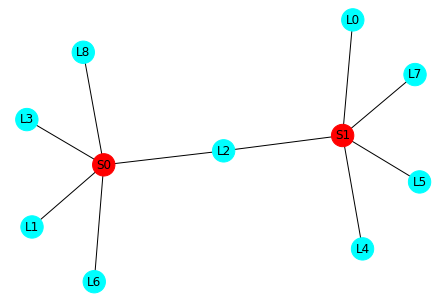

In [24]:
nviz.plot_soma_limb_concept_network(neuron_obj)

# calculating the statistics to be stored in the table

In [27]:
recovered_neuron = neuron_obj

In [30]:
import neuron_utils as nru
import numpy as np
n_error_limbs = len(nru.error_limb_indexes(recovered_neuron))

n_somas = len(recovered_neuron.get_soma_node_names())

n_limbs = len(recovered_neuron.get_limb_node_names())

n_branches_per_limb = [len(ex_limb.get_branch_names()) for ex_limb in recovered_neuron]
n_branches = np.sum(n_branches_per_limb)

n_spines = len(recovered_neuron.spines)

#for total skeletal length
sk_len_per_branch = [sk.calculate_skeleton_distance(limb.skeleton) for limb in recovered_neuron]
skeletal_length = np.sum(sk_len_per_branch)

if skeletal_length > 0:
    spine_density = n_spines/skeletal_length
else:
    spine_density = 0

max_limb_skeletal_length = np.max(sk_len_per_branch)

max_limb_n_branches = np.max(n_branches_per_limb)

new_key = dict(n_error_limbs=n_error_limbs,
                n_somas=n_somas,
                n_limbs=n_limbs,
                n_branches=n_branches,
                n_spines=n_spines,
                skeletal_length=skeletal_length,
                spine_density=spine_density,
                max_limb_skeletal_length=max_limb_skeletal_length,
                max_limb_n_branches=max_limb_n_branches)

# Jake Stats

In [54]:
#median 

all_skeletal_lengths = []
all_widths_no_spine = []
all_widths = []

n_spine_eligible_branches = 0
spine_eligible_branch_lengths = []

for curr_limb in recovered_neuron:
    for curr_branch in curr_limb:
        curr_branch_sk_len = sk.calculate_skeleton_distance(curr_branch.skeleton)
        all_skeletal_lengths.append(curr_branch_sk_len)
        all_widths_no_spine.append(curr_branch.width_new["no_spine_median_mesh_center"])
        all_widths.append(curr_branch.width_new["median_mesh_center"])
        
        if not curr_branch.spines is None:
            spine_eligible_branch_lengths.append(curr_branch_sk_len)
            n_spine_eligible_branches += 1
            
all_skeletal_lengths = np.array(all_skeletal_lengths)
median_branch_length = np.round(np.median(all_skeletal_lengths),3)

In [83]:
#spines per branch
if n_branches > 0:
    spines_per_branch = np.round(n_spines/n_branches,3)
else:
    spines_per_branch = 0

In [56]:
#width data
width_median = np.round(np.median(all_widths),3)
width_no_spine_median = np.round(np.median(all_widths_no_spine),3)

width_90_perc = np.round(np.percentile(all_widths,90),3)
width_no_spine_90_perc = np.round(np.percentile(all_widths_no_spine,90),3)


width_median,width_no_spine_median,width_90_perc,width_no_spine_90_perc

(122.523, 122.523, 483.228, 455.873)

In [59]:
#spine eligible density and per branch
skeletal_length_eligible = np.sum(spine_eligible_branch_lengths)
if skeletal_length_eligible > 0:
    spine_density_eligible = n_spines/skeletal_length_eligible
else:
    spine_density_eligible = 0

if n_branches > 0:
    spines_per_branch_eligible = np.round(n_spines/n_spine_eligible_branches,3)
else:
    spines_per_branch_eligible = 0

skeletal_length_eligible,n_spine_eligible_branches,spine_density_eligible,spines_per_branch_eligible

(3372732.1718796734, 87, 0.0004082743395638728, 15.828)

In [94]:
tu.split_significant_pieces(total_spines[0],significance_threshold=15)

[<trimesh.Trimesh(vertices.shape=(134, 3), faces.shape=(263, 3))>]

# spine volume

In [80]:
import trimesh_utils as tu
tu = reload(tu)

(array([   0.,    0.,    0.,    0.,    0., 1377.,    0.,    0.,    0.,
           0.]),
 array([-2.26657502e+08, -2.26657502e+08, -2.26657502e+08, -2.26657502e+08,
        -2.26657502e+08, -2.26657501e+08, -2.26657501e+08, -2.26657501e+08,
        -2.26657501e+08, -2.26657501e+08, -2.26657501e+08]),
 <BarContainer object of 10 artists>)

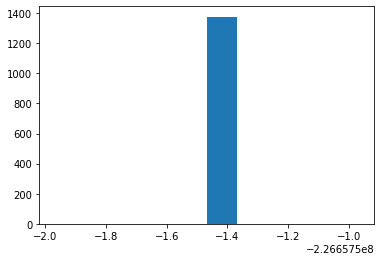

In [86]:
import matplotlib.pyplot as plt
plt.hist(total_volume)

In [87]:
tu = reload(tu)
spine_time = time.time()
total_spines = recovered_neuron.spines
total_volume =[]
for ts in total_spines:
#     vol = tu.mesh_volume(total_spines[0],
#                              watertight_method=None,
#                              return_closed_mesh=False,
#                      verbose=False)
    vol = tu.mesh_volume_o3d(ts)
    total_volume.append(vol)
    
print(f"Total time for calculating spine volume = {time.time() - spine_time}")
total_volume = np.array(total_volume)

spine_volume_median = np.median(total_volume)

total_spine_volume = np.sum(total_volume)

if skeletal_length > 0:
    spine_volume_density = total_spine_volume/skeletal_length
else:
    spine_volume_density = 0


if skeletal_length_eligible > 0:
    spine_volume_density_eligible = total_spine_volume/skeletal_length_eligible
else:
    spine_volume_density_eligible = 0

if n_branches > 0:
    spine_volume_per_branch_eligible = np.round(total_spine_volume/n_spine_eligible_branches,3)
else:
    spine_volume_per_branch_eligible = 0


RuntimeError: [1;31m[Open3D ERROR] The mesh is not watertight, and the volume cannot be computed.[0;m

In [84]:
new_key = dict(         n_error_limbs=n_error_limbs,
                        n_somas=n_somas,
                        n_limbs=n_limbs,
                        n_branches=n_branches,
                        max_limb_n_branches=max_limb_n_branches,
                       
                        skeletal_length=skeletal_length,
                        max_limb_skeletal_length=max_limb_skeletal_length,
                        median_branch_length=median_branch_length,

                        width_median=width_median, #median width from mesh center without spines removed
                        width_no_spine_median=width_no_spine_median, #median width from mesh center with spines removed
                        width_90_perc=width_90_perc, # 90th percentile for width without spines removed
                        width_no_spine_90_perc=width_no_spine_90_perc,  # 90th percentile for width with spines removed

                        n_spines=n_spines,

                        spine_density=spine_density, # n_spines/ skeletal_length
                        spines_per_branch=spines_per_branch,

                        skeletal_length_eligible=skeletal_length_eligible, # the skeletal length for all branches searched for spines
                        n_spine_eligible_branches=n_spine_eligible_branches,

                        total_spine_volume=total_spine_volume, # the sum of all spine volume
                        spine_volume_density=spine_volume_density, #total_spine_volume/skeletal_length
                        spine_volume_density_eligible=spine_volume_density_eligible, #total_spine_volume/skeletal_length_eligible
                        spine_volume_per_branch_eligible=spine_volume_per_branch_eligible, #total_spine_volume/n_spine_eligible_branche

                       
                      )

In [85]:
new_key

{'n_error_limbs': 2,
 'n_somas': 2,
 'n_limbs': 9,
 'n_branches': 220,
 'max_limb_n_branches': 52,
 'skeletal_length': 6364170.693847561,
 'max_limb_skeletal_length': 1624520.8964276644,
 'median_branch_length': 14473.069,
 'width_median': 122.523,
 'width_no_spine_median': 122.523,
 'width_90_perc': 483.228,
 'width_no_spine_90_perc': 455.873,
 'n_spines': 1377,
 'spine_density': 0.00021636754673019505,
 'spines_per_branch': 6.259,
 'skeletal_length_eligible': 3372732.1718796734,
 'n_spine_eligible_branches': 87,
 'total_spine_volume': -312107379521.103,
 'spine_volume_density': -49041.32754057442,
 'spine_volume_density_eligible': -92538.4417189465,
 'spine_volume_per_branch_eligible': -3587441143.921}

# Debugging the Concept Network Error

In [ ]:
# limb_correspondence = limb_correspondence_with_floating_pieces[curr_limb_idx]
# touching_verts_list = limb_network_stating_info[curr_limb_idx]["touching_verts_list"]
# endpoints_must_keep = limb_network_stating_info[curr_limb_idx]["endpoints_must_keep"]
# run_concept_network_checks=True
# """
# Can take a limb correspondence and the starting vertices and endpoints
# and create a list of concept networks organized by 
# [soma_idx] --> list of concept networks 
#                 (because could possibly have mulitple starting points on the same soma)

# """
# curr_touching_verts_list = touching_verts_list
# curr_endpoints_must_keep = endpoints_must_keep
# limb_correspondence_individual = limb_correspondence
# divided_skeletons = np.array([limb_correspondence_individual[k]["branch_skeleton"] for k in np.sort(list(limb_correspondence_individual.keys()))])



# # -------------- Part 18: Getting Concept Networks  [soma_idx] --> list of concept networks -------#

# """
# Concept Network Pseudocode:

# Step 0: Compile the Limb correspondence into final form

# Make sure these have the same list
# limb_to_soma_touching_vertices_list,limb_to_endpoints_must_keep_list

# For every dictionary in zip(limb_to_soma_touching_vertices_list,
#                         limb_to_endpoints_must_keep_list):

#     #make sure the dicts have same keys
#     For every key (represents the soma) in the dictionary:

#         #make sure the lists have the same sizes
#         For every item in the list (which would be a list of endpoints or list of groups of vertexes):
#             #At this point have the soma, the endpoint and the touching vertices

#             1) find the branch with the endoint that must keep
#                 --> if multiple endpoints then error
#             2) Call the branches_to_concept_network with the
#                a. divided skeletons
#                b. closest endpoint
#                c. endpoints of branch (from the branch found)
#                d. touching soma vertices

#             3) Run the checks on the concept network

# """



# limb_to_soma_concept_networks = dict()

# if len(curr_touching_verts_list) != len(curr_endpoints_must_keep):
#     raise Exception(f"curr_touching_verts_list ({curr_touching_verts_list}) not same size as curr_endpoints_must_keep ({len(curr_endpoints_must_keep)})")

# for touch_vert_dict,endpoints_keep_dict in zip(curr_touching_verts_list,curr_endpoints_must_keep):
#     if not np.array_equal(list(touch_vert_dict.keys()),list(endpoints_keep_dict.keys())):
#         raise Exception(f"touch_vert_dict keys ({touch_vert_dict.keys()}) don't match endpoints_keep_dict keys ({endpoints_keep_dict.keys()})")
#     for soma_idx in touch_vert_dict.keys():
#         soma_t_verts_list = touch_vert_dict[soma_idx]
#         soma_endpt_list = endpoints_keep_dict[soma_idx]

#         if soma_idx not in list(limb_to_soma_concept_networks.keys()):
#             limb_to_soma_concept_networks[soma_idx] = []

#         if len(soma_t_verts_list) != len(soma_endpt_list):
#             raise Exception(f"soma_t_verts_list length ({len(soma_t_verts_list)}) not equal to soma_endpt_list length ({soma_endpt_list})")
#         for soma_group_idx,(t_verts,endpt) in enumerate(zip(soma_t_verts_list,soma_endpt_list)):



#             #1) find the branch with the endoint that must keep
#             start_branch = sk.find_branch_skeleton_with_specific_coordinate(divded_skeleton=divided_skeletons,
#                                                             current_coordinate=endpt)[0]
#             #print(f"Starting_branch = {start_branch}")
#             #print(f"Start endpt = {endpt}")
#             start_branch_endpoints = sk.find_branch_endpoints(divided_skeletons[start_branch])
#             #print(f"Starting_branch endpoints = {start_branch_endpoints}")

#             #2) Call the branches_to_concept_network with the
#             curr_limb_concept_network = nru.branches_to_concept_network(curr_branch_skeletons=divided_skeletons,
#                                                                   starting_coordinate=endpt,
#                                                                   starting_edge=start_branch_endpoints,
#                                                                   touching_soma_vertices=t_verts,
#                                                                        soma_group_idx=soma_group_idx)
#             print("Done generating concept network \n\n")


#             run_checks = True
#             check_print_flag = True

#             if run_concept_network_checks:
#                 #3) Run the checks on the concept network
#                 #3.1: check to make sure the starting coordinate was recovered

#                 recovered_touching_piece = xu.get_nodes_with_attributes_dict(curr_limb_concept_network,dict(starting_coordinate=endpt))

#                 if check_print_flag:
#                     print(f"recovered_touching_piece = {recovered_touching_piece}")
#                 if recovered_touching_piece[0] != start_branch:
#                     raise Exception(f"For limb and soma {soma_idx} the recovered_touching and original touching do not match\n"
#                                    f"recovered_touching_piece = {recovered_touching_piece}, original_touching_pieces = {start_branch}")


#                 #3.2: Check number of nodes match the number of divided skeletons
#                 if len(curr_limb_concept_network.nodes()) != len(divided_skeletons):
#                     raise Exception("The number of nodes in the concept graph and number of branches passed to it did not match\n"
#                                   f"len(curr_limb_concept_network.nodes())={len(curr_limb_concept_network.nodes())}, len(curr_limb_divided_skeletons)= {len(divided_skeletons)}")

#                 #3.3: Check that concept network is a connected component
#                 if nx.number_connected_components(curr_limb_concept_network) > 1:
#                     raise Exception("There was more than 1 connected components in the concept network")


#                 #3.4 Make sure the oriiginal divided skeleton endpoints match the concept map endpoints
#                 for j,un_resized_b in enumerate(divided_skeletons):
#                     """
#                     Pseudocode: 
#                     1) get the endpoints of the current branch
#                     2) get the endpoints in the concept map
#                     3) compare
#                     - if not equalt then break
#                     """
#                     #1) get the endpoints of the current branch
#                     b_endpoints = neuron.Branch(un_resized_b).endpoints
#                     #2) get the endpoints in the concept map
#                     graph_endpoints = xu.get_node_attributes(curr_limb_concept_network,attribute_name="endpoints",node_list=[j])[0]
#                     #print(f"original_branch_endpoints = {b_endpoints}, concept graph node endpoints = {graph_endpoints}")
#                     if not xu.compare_endpoints(b_endpoints,graph_endpoints):
#                         raise Exception(f"The node {j} in concept graph endpoints do not match the endpoints of the original branch\n"
#                                        f"original_branch_endpoints = {b_endpoints}, concept graph node endpoints = {graph_endpoints}")

#             limb_to_soma_concept_networks[soma_idx].append(curr_limb_concept_network)

# return_value = limb_to_soma_concept_networks

In [ ]:
import neuron_visualizations as nviz

In [ ]:
nviz.plot_objects(meshes=seperate_soma_meshes,
                  skeletons=divided_skeletons,
                 skeletons_colors="random",
                 scatters=[endpt.reshape(-1,3)],
                 scatter_size=0.1,
                )

In [ ]:
sk.find_branch_skeleton_with_specific_coordinate(divded_skeleton=divided_skeletons,
                                                            current_coordinate=endpt)

In [ ]:
neuron = reload(neuron)
nru = reload(nru)

In [ ]:
nviz.visualize_neuron(neuron_obj,
                      visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")

In [ ]:
nviz.plot_spines(neuron_obj)

In [ ]:
nviz.plot_soma_limb_concept_network(neuron_obj)

In [ ]:
nviz.plot_objects(meshes=neuron_obj.not_processed_soma_containing_meshes + neuron_obj.inside_pieces)

In [ ]:
nru = reload(nru)
neuron = reload(neuron)

In [ ]:
neuron_obj.save_compressed_neuron(output_folder="/notebooks/test_neurons/Fusion_decomp/",file_name="seperated_somas",return_file_path=True,export_mesh=False)

In [ ]:
my_file = "/notebooks/test_neurons/Fusion_decomp/seperated_somas"
recov_neuron = nru.decompress_neuron(my_file,my_file,suppress_output=False)

In [ ]:
nviz.visualize_neuron(recov_neuron,
                      visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")

# Debugging the Decompress 

In [ ]:
nviz.plot_objects(neuron_obj[0][61].mesh)

# Debugging the Limb

In [ ]:
curr_limb_idx

In [ ]:
from preprocessing_vp2 import *
sk = reload(sk)
pre=reload(pre)
xu = reload(xu)



#Arguments to pass to the specific function (when working with a limb)
soma_touching_vertices_dict = piece_to_soma_touching_vertices[curr_limb_idx]
curr_limb_idx = 0
mesh=current_mesh_data[0]["branch_meshes"][curr_limb_idx]



distance_by_mesh_center=True #how the distance is calculated for mesh correspondence
meshparty_segment_size = 100
meshparty_n_surface_downsampling = 2
combine_close_skeleton_nodes=True
combine_close_skeleton_nodes_threshold=700
filter_end_node_length=1500
use_meshafterparty=True
perform_cleaning_checks = True

#for controlling the pieces processed by MAP
width_threshold_MAP = 450
size_threshold_MAP = 1000

#parameters for MP skeletonization,

#Parameters for setting how the MAP skeletonization takes place
use_surface_after_CGAL=False
surface_reconstruction_size = 500

#parametrers for stitching the MAP and MP pieces together
move_MAP_stitch_to_end_or_branch = True
distance_to_move_point_threshold=500

#concept_network parameters
run_concept_network_checks = True
return_concept_network = True
return_concept_network_starting_info=False

#printing controls
verbose = True
print_fusion_steps=True


#arguments
return_concept_network = False
return_concept_network_starting_info=True
width_threshold_MAP=500
size_threshold_MAP=2000
surface_reconstruction_size=1000
                    
                   
    
curr_limb_time = time.time()
    
limb_mesh_mparty = mesh


#will store a list of all the endpoints tha tmust be kept:
limb_to_endpoints_must_keep_list = []
limb_to_soma_touching_vertices_list = []

# --------------- Part 1 and 2: Getting Border Vertices and Setting the Root------------- #
fusion_time = time.time()
#will eventually get the current root from soma_to_piece_touching_vertices[i]
if not soma_touching_vertices_dict is None:
    root_curr = soma_touching_vertices_dict[list(soma_touching_vertices_dict.keys())[0]][0][0]
else:
    root_curr = None

if print_fusion_steps:
    print(f"Time for preparing soma vertices and root: {time.time() - fusion_time }")
    fusion_time = time.time()

# --------------- Part 3: Meshparty skeletonization and Decomposition ------------- #
sk_meshparty_obj = m_sk.skeletonize_mesh_largest_component(limb_mesh_mparty,
                                                        root=root_curr,
                                                          filter_mesh=False)

if print_fusion_steps:
    print(f"Time for 1st pass MP skeletonization: {time.time() - fusion_time }")
    fusion_time = time.time()

(segment_branches, #skeleton branches
divided_submeshes, divided_submeshes_idx, #mesh correspondence (mesh and indices)
segment_widths_median) = m_sk.skeleton_obj_to_branches(sk_meshparty_obj,
                                                      mesh = limb_mesh_mparty,
                                                      meshparty_segment_size=meshparty_segment_size)




if print_fusion_steps:
    print(f"Decomposing first pass: {time.time() - fusion_time }")
    fusion_time = time.time()


if use_meshafterparty:
    print("Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence")
    # --------------- Part 4: Find Individual Branches that could be MAP processed because of width ------------- #
    #gettin the branches that should be passed through MAP skeletonization
    pieces_above_threshold = np.where(segment_widths_median>width_threshold_MAP)[0]

    #getting the correspondnece info for those MAP qualifying
    width_large = segment_widths_median[pieces_above_threshold]
    sk_large = [segment_branches[k] for k in pieces_above_threshold]
    mesh_large_idx = [divided_submeshes_idx[k] for k in pieces_above_threshold]
else:
    print("Only Using MeshParty Skeletonization and Mesh Correspondence")
    mesh_large_idx = []
    width_large = []
    sk_large = []


print("Another print")
mesh_pieces_for_MAP = []
mesh_pieces_for_MAP_face_idx = []


if len(mesh_large_idx) > 0: #will only continue processing if found MAP candidates

    # --------------- Part 5: Find mesh connectivity and group MAP branch candidates into MAP sublimbs ------------- #
    print(f"Found len(mesh_large_idx) MAP candidates: {[len(k) for k in mesh_large_idx]}")

    #finds the connectivity edges of all the MAP candidates
    mesh_large_connectivity = tu.mesh_list_connectivity(meshes = mesh_large_idx,
                            main_mesh = limb_mesh_mparty,
                            print_flag = False)
    if print_fusion_steps:
        print(f"mesh_large_connectivity: {time.time() - fusion_time }")
        fusion_time = time.time()
    """
    --------------- Grouping MAP candidates ----------------
    Purpose: Will see what mesh pieces should be grouped together
    to pass through CGAL skeletonization


    Pseudocode: 
    1) build a networkx graph with all nodes for mesh_large_idx indexes
    2) Add the edges
    3) Find the connected components
    4) Find sizes of connected components
    5) For all those connected components that are of a large enough size, 
    add the mesh branches and skeletons to the final list


    """
    G = nx.Graph()
    G.add_nodes_from(np.arange(len(mesh_large_idx)))
    G.add_edges_from(mesh_large_connectivity)
    conn_comp = list(nx.connected_components(G))

    filtered_pieces = []

    sk_large_size_filt = []
    mesh_large_idx_size_filt = []
    width_large_size_filt = []

    for cc in conn_comp:
        total_cc_size = np.sum([len(mesh_large_idx[k]) for k in cc])
        if total_cc_size>size_threshold_MAP:
            #print(f"cc ({cc}) passed the size threshold because size was {total_cc_size}")
            filtered_pieces.append(pieces_above_threshold[list(cc)])

    if print_fusion_steps:
        print(f"Finding MAP candidates connected components: {time.time() - fusion_time }")
        fusion_time = time.time()

    #filtered_pieces: will have the indexes of all the branch candidates that should  be 
    #grouped together and passed through MAP skeletonization

    if len(filtered_pieces) > 0:
        # --------------- Part 6: If Found MAP sublimbs, Get the meshes and mesh_idxs of the sublimbs ------------- #
        print(f"len(filtered_pieces) = {len(filtered_pieces)}")
        #all the pieces that will require MAP mesh correspondence and skeletonization
        #(already organized into their components)
        mesh_pieces_for_MAP = [limb_mesh_mparty.submesh([np.concatenate(divided_submeshes_idx[k])],append=True,repair=False) for k in filtered_pieces]
        mesh_pieces_for_MAP_face_idx = [np.concatenate(divided_submeshes_idx[k]) for k in filtered_pieces]



        """
        Old Way: Finding connectivity of pieces through
        mesh_idx_MP = [divided_submeshes_idx[k] for k in pieces_idx_MP]

        mesh_large_connectivity_MP = tu.mesh_list_connectivity(meshes = mesh_idx_MP,
                                main_mesh = limb_mesh_mparty,
                                print_flag = False)

        New Way: going to use skeleton connectivity to determine
        connectivity of pieces

        Pseudocode: 
        1)

        """
        # --------------- Part 7: If Found MAP sublimbs, Get the meshes and mesh_idxs of the sublimbs ------------- #
        # ********* if there are no pieces leftover then will automatically make all the lists below just empty (don't need to if.. else.. the case)****
        pieces_idx_MP = np.setdiff1d(np.arange(len(divided_submeshes_idx)),np.concatenate(filtered_pieces))

        skeleton_MP = [segment_branches[k] for k in pieces_idx_MP]
        skeleton_connectivity_MP = sk.skeleton_list_connectivity(
                                        skeletons=skeleton_MP
                                        )
        if print_fusion_steps:
            print(f"skeleton_connectivity_MP : {time.time() - fusion_time }")
            fusion_time = time.time()

        G = nx.Graph()
        G.add_nodes_from(np.arange(len(skeleton_MP)))
        G.add_edges_from(skeleton_connectivity_MP)
        sublimbs_MP = list(nx.connected_components(G))
        sublimbs_MP_orig_idx = [pieces_idx_MP[list(k)] for k in sublimbs_MP]


        #concatenate into sublimbs the skeletons and meshes
        sublimb_mesh_idx_branches_MP = [divided_submeshes_idx[k] for k in sublimbs_MP_orig_idx]
        sublimb_mesh_branches_MP = [[limb_mesh_mparty.submesh([ki],append=True,repair=False)
                                    for ki in k] for k in sublimb_mesh_idx_branches_MP]
        sublimb_meshes_MP = [limb_mesh_mparty.submesh([np.concatenate(k)],append=True,repair=False)
                                                     for k in sublimb_mesh_idx_branches_MP]
        sublimb_meshes_MP_face_idx = [np.concatenate(k)
                                                     for k in sublimb_mesh_idx_branches_MP]
        sublimb_skeleton_branches = [segment_branches[k] for k in sublimbs_MP_orig_idx]
        widths_MP = [segment_widths_median[k] for k in sublimbs_MP_orig_idx]

        if print_fusion_steps:
            print(f"Grouping MP Sublimbs by Graph: {time.time() - fusion_time }")
            fusion_time = time.time()


# else: #if no pieces were determine to need MAP processing
#     print("No MAP processing needed: just returning the Meshparty skeletonization and mesh correspondence")
#     raise Exception("Returning MP correspondence")


# nviz.plot_objects(main_mesh=tu.combine_meshes([limb_mesh_mparty,current_neuron["S0"].mesh]),
#                   main_mesh_color="green",
#     skeletons=sk_large_size_filt,
#      meshes=[limb_mesh_mparty.submesh([k],append=True) for k in mesh_large_idx_size_filt],
#       meshes_colors="red")








# --------------- Part 8: If No MAP sublimbs found, set the MP sublimb lists to just the whole MP branch decomposition ------------- #

#if no sublimbs need to be decomposed with MAP then just reassign all of the previous MP processing to the sublimb_MPs
if len(mesh_pieces_for_MAP) == 0:
    sublimb_meshes_MP = [limb_mesh_mparty] #trimesh pieces that have already been passed through MP skeletonization (may not need)
    # -- the decomposition information ---
    sublimb_mesh_branches_MP = [divided_submeshes] #the mesh branches for all the disconnected sublimbs
    sublimb_mesh_idx_branches_MP = [divided_submeshes_idx] #The mesh branches idx that have already passed through MP skeletonization
    sublimb_skeleton_branches = [segment_branches]#the skeleton bnraches for all the sublimbs
    widths_MP = [segment_widths_median] #the mesh branches widths for all the disconnected groups

    MAP_flag = False
else:
    MAP_flag = True



mesh_pieces_for_MAP #trimesh pieces that should go through CGAL skeletonization
sublimb_meshes_MP #trimesh pieces that have already been passed through MP skeletonization (may not need)

# -- the decomposition information ---
sublimb_mesh_branches_MP #the mesh branches for all the disconnected sublimbs
sublimb_mesh_idx_branches_MP #The mesh branches idx that have already passed through MP skeletonization
sublimb_skeleton_branches #the skeleton bnraches for all the sublimbs
widths_MP #the mesh branches widths for all the disconnected groups

if print_fusion_steps:
    print(f"Divinding into MP and MAP pieces: {time.time() - fusion_time }")
    fusion_time = time.time()



# ------------------- At this point have the correct division between MAP and MP ------------------------

# -------------- Part 9: Doing the MAP decomposition ------------------ #
global_start_time = time.time()
endpoints_must_keep = dict()



limb_correspondence_MAP = dict()

for sublimb_idx,(mesh,mesh_idx) in enumerate(zip(mesh_pieces_for_MAP,mesh_pieces_for_MAP_face_idx)):
    print(f"--- Working on MAP piece {sublimb_idx}---")
    mesh_start_time = time.time()
    curr_soma_to_piece_touching_vertices = filter_soma_touching_vertices_dict_by_mesh(
    mesh = mesh,
    curr_piece_to_soma_touching_vertices = soma_touching_vertices_dict
    )

    if print_fusion_steps:
        print(f"MAP Filtering Soma Pieces: {time.time() - fusion_time }")
        fusion_time = time.time()

    # ---- 0) Generating the Clean skeletons  -------------------------------------------#
    if not curr_soma_to_piece_touching_vertices is None:
        curr_total_border_vertices = dict([(k,np.vstack(v)) for k,v in curr_soma_to_piece_touching_vertices.items()])
    else:
        curr_total_border_vertices = None


    cleaned_branch,curr_limb_endpoints_must_keep = sk.skeletonize_and_clean_connected_branch_CGAL(
        mesh=mesh,
        curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices,
        total_border_vertices=curr_total_border_vertices,
        filter_end_node_length=filter_end_node_length,
        perform_cleaning_checks=perform_cleaning_checks,
        combine_close_skeleton_nodes = combine_close_skeleton_nodes,
        combine_close_skeleton_nodes_threshold=combine_close_skeleton_nodes_threshold,
    use_surface_after_CGAL=use_surface_after_CGAL,
    surface_reconstruction_size=surface_reconstruction_size)

    if not curr_limb_endpoints_must_keep is None:
        limb_to_endpoints_must_keep_list.append(curr_limb_endpoints_must_keep)
        limb_to_soma_touching_vertices_list.append(curr_soma_to_piece_touching_vertices)
    else:
        print("Inside MAP decomposition and curr_limb_endpoints_must_keep was None")

    if len(cleaned_branch) == 0:
        raise Exception(f"Found a zero length skeleton for limb {z} of trmesh {branch}")

    if print_fusion_steps:
        print(f"skeletonize_and_clean_connected_branch_CGAL: {time.time() - fusion_time }")
        fusion_time = time.time()

    # ---- 1) Generating Initial Mesh Correspondence -------------------------------------------#
    start_time = time.time()

    print(f"Working on limb correspondence for #{sublimb_idx} MAP piece")
    local_correspondence = mesh_correspondence_first_pass(mesh=mesh,
                                                         skeleton=cleaned_branch,
                                                         distance_by_mesh_center=distance_by_mesh_center)


    print(f"Total time for decomposition = {time.time() - start_time}")
    if print_fusion_steps:
        print(f"mesh_correspondence_first_pass: {time.time() - fusion_time }")
        fusion_time = time.time()


    #------------- 2) Doing Some checks on the initial corespondence -------- #


    if perform_cleaning_checks:
        check_skeletonization_and_decomp(skeleton=cleaned_branch,
                                        local_correspondence=local_correspondence)

    # -------3) Finishing off the face correspondence so get 1-to-1 correspondence of mesh face to skeletal piece
    local_correspondence_revised = correspondence_1_to_1(mesh=mesh,
                                    local_correspondence=local_correspondence,
                                    curr_limb_endpoints_must_keep=curr_limb_endpoints_must_keep,
                                    curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices)

    # -------3b) Fixing the mesh indices to correspond to the larger mesh as a whole
    for k,v in local_correspondence_revised.items():
        local_correspondence_revised[k]["branch_face_idx"] = mesh_idx[local_correspondence_revised[k]["branch_face_idx"]]

    print(f"Total time for MAP sublimb #{sublimb_idx} mesh processing = {time.time() - mesh_start_time}")

    if print_fusion_steps:
        print(f"correspondence_1_to_1: {time.time() - fusion_time }")
        fusion_time = time.time()

    limb_correspondence_MAP[sublimb_idx] = local_correspondence_revised

print(f"Total time for MAP sublimb processing {time.time() - global_start_time}")





# ----------------- Part 10: Doing the MP Decomposition ---------------------- #




sublimb_meshes_MP #trimesh pieces that have already been passed through MP skeletonization (may not need)
# -- the decomposition information ---
sublimb_mesh_branches_MP #the mesh branches for all the disconnected sublimbs
sublimb_mesh_idx_branches_MP #The mesh branches idx that have already passed through MP skeletonization
sublimb_skeleton_branches #the skeleton bnraches for all the sublimbs
widths_MP #the mesh branches widths for all the disconnected groups

limb_correspondence_MP = dict()

for sublimb_idx,mesh in enumerate(sublimb_meshes_MP):
    print(f"---- Working on MP Decomposition #{sublimb_idx} ----")
    mesh_start_time = time.time()

    if len(sublimb_meshes_MP) == 1 and MAP_flag == False:
        print("Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece ")
        curr_soma_to_piece_touching_vertices = soma_touching_vertices_dict
    else:
        if not soma_touching_vertices_dict is None:
            print("Computing the current soma touching verts dict manually")
            curr_soma_to_piece_touching_vertices = filter_soma_touching_vertices_dict_by_mesh(
                                                mesh = mesh,
                                                curr_piece_to_soma_touching_vertices = soma_touching_vertices_dict
                                                )
        else:
            curr_soma_to_piece_touching_vertices = None

    if print_fusion_steps:
        print(f"MP filtering soma verts: {time.time() - fusion_time }")
        fusion_time = time.time()

    #creating all of the sublimb groups
    segment_branches = np.array(sublimb_skeleton_branches[sublimb_idx])
    whole_sk_MP = sk.stack_skeletons(segment_branches)
    branch = mesh
    divided_submeshes = np.array(sublimb_mesh_branches_MP[sublimb_idx])
    divided_submeshes_idx = sublimb_mesh_idx_branches_MP[sublimb_idx]
    segment_widths_median = widths_MP[sublimb_idx]


    if curr_soma_to_piece_touching_vertices is None:
        print(f"Do Not Need to Fix MP Decomposition {sublimb_idx} so just continuing")

    else:
        
        # ------- 11/9 addition: Fixing error where creating soma touching branch on mesh that doesn't touch border ------------------- #
        print(f"Fixing Possible Soma Extension Branch for Sublimb {sublimb_idx}")
        no_soma_extension_add = True 
        
        endpts_total = dict()
        curr_soma_to_piece_touching_vertices_total = dict()
        for sm_idx,sm_bord_verts_list in curr_soma_to_piece_touching_vertices.items():
            #will be used for later
            endpts_total[sm_idx] = []
            curr_soma_to_piece_touching_vertices_total[sm_idx] = []
            
            for sm_bord_verts in sm_bord_verts_list:
                #1) Get the mesh pieces that are touching the border
                matching_mesh_idx = tu.filter_meshes_by_containing_coordinates(mesh_list=divided_submeshes,
                                           nullifying_points=sm_bord_verts,
                                            filter_away=False,
                                           distance_threshold=0,
                                           return_indices=True)
                #2) concatenate all meshes and skeletons that are touching
                if len(matching_mesh_idx) <= 0:
                    raise Exception("None of branches were touching the border vertices when fixing MP pieces")
                
                touch_mesh = tu.combine_meshes(divided_submeshes[matching_mesh_idx])
                touch_sk = sk.stack_skeletons(segment_branches[matching_mesh_idx])
                
                local_curr_soma_to_piece_touching_vertices = {sm_idx:[sm_bord_verts]}
                new_sk,endpts,new_branch_info = sk.create_soma_extending_branches(current_skeleton=touch_sk,
                                      skeleton_mesh=touch_mesh,
                                      soma_to_piece_touching_vertices=local_curr_soma_to_piece_touching_vertices,
                                      return_endpoints_must_keep=True,
                                      return_created_branch_info=True,
                                      check_connected_skeleton=False)
                
                #3) Add the info to the new running lists
                endpts_total[sm_idx].append(endpts[sm_idx][0])
                curr_soma_to_piece_touching_vertices_total[sm_idx].append(sm_bord_verts)
                
                
                #4) Skip if no new branch was added
                br_info = new_branch_info[sm_idx][0]
                if br_info is None:
                    print("The new branch info was none so skipping \n")
                    continue
                    
                #4 If new branch was made then 
                no_soma_extension_add=False

                #1) Get the newly added branch (and the original vertex which is the first row)
                br_new,sm_bord_verts = br_info["new_branch"],br_info["border_verts"] #this will hold the new branch and the border vertices corresponding to it

                curr_soma_to_piece_touching_vertices_MP = {sm_idx:[sm_bord_verts]}
                endpoints_must_keep_MP = {sm_idx:[br_new[0][1]]}


                orig_vertex = br_new[0][0]
                print(f"orig_vertex = {orig_vertex}")

                #2) Find the branches that have that coordinate (could be multiple)
                match_sk_branches = sk.find_branch_skeleton_with_specific_coordinate(segment_branches,
                    current_coordinate=orig_vertex)

                print(f"match_sk_branches = {match_sk_branches}")



                """ ******************* THIS NEEDS TO BE FIXED WITH THE SAME METHOD OF STITCHING ********************  """
                """
                Pseudocode:
                1) Find if branch point will require split or not
                2) If does require split then split the skeleton
                3) Gather mesh pieces for correspondence and the skeletons
                4) Run the mesh correspondence
                - this case calculate the new widths after run 
                5) Replace the old branch parts with the new ones



                """

                stitch_point_on_end_or_branch = find_if_stitch_point_on_end_or_branch(
                                                        matched_branches_skeletons= segment_branches[match_sk_branches],
                                                         stitch_coordinate=orig_vertex,
                                                          verbose=False)


                if not stitch_point_on_end_or_branch:
                    matching_branch_sk = sk.cut_skeleton_at_coordinate(skeleton=segment_branches[match_sk_branches][0],
                                                                      cut_coordinate = orig_vertex)
                else:
                    matching_branch_sk = segment_branches[match_sk_branches]


                #3) Find the mesh and skeleton of the winning branch
                matching_branch_meshes = np.array(divided_submeshes)[match_sk_branches]
                matching_branch_mesh_idx = np.array(divided_submeshes_idx)[match_sk_branches]
                extend_soma_mesh_idx = np.concatenate(matching_branch_mesh_idx)
                extend_soma_mesh = limb_mesh_mparty.submesh([extend_soma_mesh_idx ],append=True,repair=False)

                #4) Add newly created branch to skeleton and divide the skeleton into branches (could make 2 or 3)
                #extended_skeleton_to_soma = sk.stack_skeletons([list(matching_branch_sk),br_new])

                sk.check_skeleton_connected_component(sk.stack_skeletons(list(matching_branch_sk) + [br_new]))

                #5) Run Adaptive mesh correspondnece using branches and mesh
                local_correspondnece_MP = mesh_correspondence_first_pass(mesh=extend_soma_mesh,
                                                                         skeleton_branches = list(matching_branch_sk) + [br_new]
                                              #skeleton=extended_skeleton_to_soma
                                                                        )

                # GETTING MESHES THAT ARE NOT FULLY CONNECTED!!
                local_correspondence_revised = correspondence_1_to_1(mesh=extend_soma_mesh,
                                                            local_correspondence=local_correspondnece_MP,
                                                            curr_limb_endpoints_must_keep=endpoints_must_keep_MP,
                                                            curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices_MP)

                # All the things that should be revised:
            #     segment_branches, #skeleton branches
            #     divided_submeshes, divided_submeshes_idx, #mesh correspondence (mesh and indices)
            #     segment_widths_median


                new_submeshes = [k["branch_mesh"] for k in local_correspondence_revised.values()]
                new_submeshes_idx = [extend_soma_mesh_idx[k["branch_face_idx"]] for k in local_correspondence_revised.values()]
                new_skeletal_branches = [k["branch_skeleton"] for k in local_correspondence_revised.values()]

                #calculate the new width
                ray_inter = tu.ray_pyembree.RayMeshIntersector(limb_mesh_mparty)
                new_widths = []
                for new_s_idx in new_submeshes_idx:
                    curr_ray_distance = tu.ray_trace_distance(mesh=limb_mesh_mparty, 
                                        face_inds=new_s_idx,
                                       ray_inter=ray_inter)
                    curr_width_median = np.median(curr_ray_distance[curr_ray_distance!=0])
                    print(f"curr_width_median = {curr_width_median}")
                    if (not np.isnan(curr_width_median)) and (curr_width_median > 0):
                        new_widths.append(curr_width_median)
                    else:
                        print(f"USING A DEFAULT WIDTH BECAUSE THE NEWLY COMPUTED ONE WAS {curr_width_median}: {segment_widths_median[match_sk_branches[0]]}")
                        new_widths.append(segment_widths_median[match_sk_branches[0]])


                #6) Remove the original branch and mesh correspondence and replace with the multiples
#                     print(f"match_sk_branches BEFORE = {match_sk_branches}")
#                     print(f"segment_branches BEFORE = {segment_branches}")
#                     print(f"len(new_skeletal_branches) = {len(new_skeletal_branches)}")
#                     print(f"new_skeletal_branches BEFORE= {new_skeletal_branches}")


                #segment_branches = np.delete(segment_branches,match_sk_branches,axis=0)
                #segment_branches = np.append(segment_branches,new_skeletal_branches,axis=0)

                segment_branches = np.array([k for i,k in enumerate(segment_branches) if i not in match_sk_branches] + new_skeletal_branches)


                divided_submeshes = np.delete(divided_submeshes,match_sk_branches,axis=0)
                divided_submeshes = np.append(divided_submeshes,new_submeshes,axis=0)


                #divided_submeshes_idx = np.delete(divided_submeshes_idx,match_sk_branches,axis=0)
                #divided_submeshes_idx = np.append(divided_submeshes_idx,new_submeshes_idx,axis=0)
                divided_submeshes_idx = np.array([k for i,k in enumerate(divided_submeshes_idx) if i not in match_sk_branches] + new_submeshes_idx)

                segment_widths_median = np.delete(segment_widths_median,match_sk_branches,axis=0)
                segment_widths_median = np.append(segment_widths_median,new_widths,axis=0)

                try:
                    debug = False
                    if debug:
                        print(f"segment_branches.shape = {segment_branches.shape}")
                        print(f"segment_branches = {segment_branches}")
                        print(f"new_skeletal_branches = {new_skeletal_branches}")
                    sk.check_skeleton_connected_component(sk.stack_skeletons(segment_branches))
                except:
                    su.compressed_pickle(local_correspondence_revised,"local_correspondence_revised")
                print("checked segment branches after soma add on")
                return_find = sk.find_branch_skeleton_with_specific_coordinate(segment_branches,
                                             orig_vertex)



                """ ******************* END OF HOW CAN DO STITCHING ********************  """

    

        limb_to_endpoints_must_keep_list.append(endpts_total)
        limb_to_soma_touching_vertices_list.append(curr_soma_to_piece_touching_vertices_total)
        
        # ------------------- 11/9 addition ------------------- #

        if no_soma_extension_add:
            print("No soma extending branch was added for this sublimb even though it had a soma border (means they already existed)")

        if print_fusion_steps:
            print(f"MP (because soma touching verts) soma extension add: {time.time() - fusion_time }")
            fusion_time = time.time()

    #building the limb correspondence
    limb_correspondence_MP[sublimb_idx] = dict()

    for zz,b_sk in enumerate(segment_branches):
        limb_correspondence_MP[sublimb_idx][zz] = dict(
            branch_skeleton = b_sk,
            width_from_skeleton = segment_widths_median[zz],
            branch_mesh = divided_submeshes[zz],
            branch_face_idx = divided_submeshes_idx[zz]
            )



#limb_correspondence_MP_saved = copy.deepcopy(limb_correspondence_MP)
#limb_correspondence_MAP_saved = copy.deepcopy(limb_correspondence_MAP)

# ------------------------------------- Part C: Will make sure the correspondences can all be stitched together --------------- #

# Only want to perform this step if both MP and MAP pieces
if len(limb_correspondence_MAP)>0 and len(limb_correspondence_MP)>0:

    # -------------- Part 11: Getting Sublimb Mesh and Skeletons and Gets connectivitiy by Mesh -------#
    # -------------(filtering connections to only MP to MAP edges)--------------- #

    # ---- Doing the mesh connectivity ---------#
    sublimb_meshes_MP = []
    sublimb_skeletons_MP = []

    for sublimb_key,sublimb_v in limb_correspondence_MP.items():
        sublimb_meshes_MP.append(tu.combine_meshes([branch_v["branch_mesh"] for branch_v in sublimb_v.values()]))
        sublimb_skeletons_MP.append(sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in sublimb_v.values()]))

        
        
    sublimb_meshes_MAP = []
    sublimb_skeletons_MAP = []


    for sublimb_key,sublimb_v in limb_correspondence_MAP.items():
        sublimb_meshes_MAP.append(tu.combine_meshes([branch_v["branch_mesh"] for branch_v in sublimb_v.values()]))
        sublimb_skeletons_MAP.append(sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in sublimb_v.values()]))

    sublimb_skeletons_MP_saved = copy.deepcopy(sublimb_skeletons_MP)
    sublimb_skeletons_MAP_saved = copy.deepcopy(sublimb_skeletons_MAP)

    mesh_conn,mesh_conn_vertex_groups = tu.mesh_list_connectivity(meshes = sublimb_meshes_MP + sublimb_meshes_MAP,
                                        main_mesh = limb_mesh_mparty,
                                        min_common_vertices=1,
                                        return_vertex_connection_groups=True,
                                        return_largest_vertex_connection_group=True,
                                        print_flag = False)
    mesh_conn_old = copy.deepcopy(mesh_conn)



    #check that every MAP piece mapped to a MP piece
    mesh_conn_filt = []
    mesh_conn_vertex_groups_filt = []
    for j,(m1,m2) in enumerate(mesh_conn):
        if m1 < len(sublimb_meshes_MP) and m2 >=len(sublimb_meshes_MP):
            mesh_conn_filt.append([m1,m2])
            mesh_conn_vertex_groups_filt.append(mesh_conn_vertex_groups[j])
    mesh_conn_filt = np.array(mesh_conn_filt)

    mesh_conn = mesh_conn_filt
    mesh_conn_vertex_groups = mesh_conn_vertex_groups_filt

    #check that the mapping should create only one connected component
    G = nx.from_edgelist(mesh_conn)



    try:
        if len(G) != len(sublimb_meshes_MP) + len(sublimb_meshes_MAP):
            raise Exception("Number of nodes in mesh connectivity graph is not equal to number of  MAP and MP sublimbs")

        connect_comp = list(nx.connected_components(G))
        if len(connect_comp)>1:
            raise Exception(f"Mesh connectivity was not one component, instead it was ({len(connect_comp)}): {connect_comp} ")
    except:
        print(f"mesh_conn_filt = {mesh_conn_filt}")
        print(f"mesh_conn_old = {mesh_conn_old}")
        mesh_conn_adjusted = np.vstack([mesh_conn[:,0],mesh_conn[:,1]-len(sublimb_meshes_MP)]).T
        print(f"mesh_conn_adjusted = {mesh_conn_adjusted}")
        print(f"len(sublimb_meshes_MP) = {len(sublimb_meshes_MP)}")
        print(f"len(sublimb_meshes_MAP) = {len(sublimb_meshes_MAP)}")
        meshes = sublimb_meshes_MP + sublimb_meshes_MAP
        #su.compressed_pickle(meshes,"meshes")
        su.compressed_pickle(sublimb_meshes_MP,"sublimb_meshes_MP")
        su.compressed_pickle(sublimb_meshes_MAP,"sublimb_meshes_MAP")
        su.compressed_pickle(limb_mesh_mparty,"limb_mesh_mparty")
        su.compressed_pickle(sublimb_skeletons_MP,"sublimb_skeletons_MP")
        su.compressed_pickle(sublimb_skeletons_MAP,"sublimb_skeletons_MAP")


        raise Exception("Something went wrong in the connectivity")


    #adjust the connection indices for MP and MAP indices
    mesh_conn_adjusted = np.vstack([mesh_conn[:,0],mesh_conn[:,1]-len(sublimb_meshes_MP)]).T






    """
    Pseudocode:
    For each connection edge:
        For each vertex connection group:
            1) Get the endpoint vertices of the MP skeleton
            2) Find the closest endpoint vertex to the vertex connection group (this is MP stitch point)
            3) Find the closest skeletal point on MAP pairing (MAP stitch) 
            4) Find the branches that have that MAP stitch point:
            5A) If the number of branches corresponding to stitch point is multipled
                --> then we are stitching at a branching oint
                i) Just add the skeletal segment from MP_stitch to MAP stitch to the MP skeletal segment
                ii) 

    """
    


    # -------------- STITCHING PHASE -------#
    stitch_counter = 0
    all_map_stitch_points = []
    for (MP_idx,MAP_idx),v_g in zip(mesh_conn_adjusted,mesh_conn_vertex_groups):
        print(f"\n---- Working on {(MP_idx,MAP_idx)} connection-----")

        """
        This old way of getting the endpoints was not good because could possibly just need
        a stitching done between original branch junction

        skeleton_MP_graph = sk.convert_skeleton_to_graph(curr_skeleton_MP)
        endpoint_nodes = xu.get_nodes_of_degree_k(skeleton_MP_graph,1)
        endpoint_nodes_coordinates = xu.get_node_attributes(skeleton_MP_graph,node_list=endpoint_nodes)
        """


        # -------------- Part 12: Find the MP and MAP stitching point and branches that contain the stitching point-------#

        """  OLD WAY THAT ALLOWED STITICHING POINTS TO NOT BE CONNECTED AT THE CONNECTING BRANCHES
        #getting the skeletons that should be stitched
        curr_skeleton_MP = sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in limb_correspondence_MP[MP_idx].values()])
        curr_skeleton_MAP = sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in limb_correspondence_MAP[MAP_idx].values()])

        #1) Get the endpoint vertices of the MP skeleton branches (so every endpoint or high degree node)
        #(needs to be inside loop because limb correspondence will change)
        curr_MP_branch_skeletons = [limb_correspondence_MP[MP_idx][k]["branch_skeleton"] for k in np.sort(list(limb_correspondence_MP[MP_idx].keys()))]
        endpoint_nodes_coordinates = np.array([sk.find_branch_endpoints(k) for k in curr_MP_branch_skeletons])
        endpoint_nodes_coordinates = np.unique(endpoint_nodes_coordinates.reshape(-1,3),axis=0)

        #2) Find the closest endpoint vertex to the vertex connection group (this is MP stitch point)
        av_vert = np.mean(v_g,axis=0)
        winning_vertex = endpoint_nodes_coordinates[np.argmin(np.linalg.norm(endpoint_nodes_coordinates-av_vert,axis=1))]
        print(f"winning_vertex = {winning_vertex}")


        #2b) Find the branch points where the winning vertex is located
        MP_branches_with_stitch_point = sk.find_branch_skeleton_with_specific_coordinate(
            divded_skeleton=curr_MP_branch_skeletons,
            current_coordinate = winning_vertex
        )
        print(f"MP_branches_with_stitch_point = {MP_branches_with_stitch_point}")


        #3) Find the closest skeletal point on MAP pairing (MAP stitch)
        MAP_skeleton_coords = np.unique(curr_skeleton_MAP.reshape(-1,3),axis=0)
        MAP_stitch_point = MAP_skeleton_coords[np.argmin(np.linalg.norm(MAP_skeleton_coords-winning_vertex,axis=1))]


        #3b) Consider if the stitch point is close enough to end or branch node in skeleton:
        # and if so then reassign
        if move_MAP_stitch_to_end_or_branch:
            MAP_stitch_point_new,change_status = sk.move_point_to_nearest_branch_end_point_within_threshold(
                                                    skeleton=curr_skeleton_MAP,
                                                    coordinate=MAP_stitch_point,
                                                    distance_to_move_point_threshold = distance_to_move_point_threshold,
                                                    verbose=True

                                                    )
            MAP_stitch_point=MAP_stitch_point_new


        #4) Find the branches that have that MAP stitch point:
        curr_MAP_branch_skeletons = [limb_correspondence_MAP[MAP_idx][k]["branch_skeleton"]
                                         for k in np.sort(list(limb_correspondence_MAP[MAP_idx].keys()))]

        MAP_branches_with_stitch_point = sk.find_branch_skeleton_with_specific_coordinate(
            divded_skeleton=curr_MAP_branch_skeletons,
            current_coordinate = MAP_stitch_point
        )



        MAP_stitch_point_on_end_or_branch = False
        if len(MAP_branches_with_stitch_point)>1:
            MAP_stitch_point_on_end_or_branch = True
        elif len(MAP_branches_with_stitch_point)==1:
            if len(nu.matching_rows(sk.find_branch_endpoints(curr_MAP_branch_skeletons[MAP_branches_with_stitch_point[0]]),
                                    MAP_stitch_point))>0:
                MAP_stitch_point_on_end_or_branch=True
        else:
            raise Exception("No matching MAP values")

    """

        #*****should only get branches that are touching....****

        #getting the skeletons that should be stitched
        curr_skeleton_MP = sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in limb_correspondence_MP[MP_idx].values()])
        curr_skeleton_MAP = sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in limb_correspondence_MAP[MAP_idx].values()])


        av_vert = np.mean(v_g,axis=0)

        # ---------------- Doing the MAP part first -------------- #
        """
        The previous way did not ensure that the MAP point found will have a branch mesh that is touching the border vertices

        #3) Find the closest skeletal point on MAP pairing (MAP stitch)
        MAP_skeleton_coords = np.unique(curr_skeleton_MAP.reshape(-1,3),axis=0)

        #this does not guarentee that the MAP branch associated with the MAP stitch point is touching the border group
        MAP_stitch_point = MAP_skeleton_coords[np.argmin(np.linalg.norm(MAP_skeleton_coords-av_vert,axis=1))]
        """

        # -------------- 11/9 NEW METHOD FOR FINDING MAP STITCH POINT ------------ #
        o_keys = np.sort(list(limb_correspondence_MAP[MAP_idx].keys()))
        curr_MAP_branch_meshes = np.array([limb_correspondence_MAP[MAP_idx][k]["branch_mesh"]
                                         for k in o_keys])
        curr_MAP_branch_skeletons = np.array([limb_correspondence_MAP[MAP_idx][k]["branch_skeleton"]
                                         for k in o_keys])

        MAP_pieces_idx_touching_border = tu.filter_meshes_by_containing_coordinates(mesh_list=curr_MAP_branch_meshes,
                                       nullifying_points=v_g,
                                        filter_away=False,
                                       distance_threshold=0,
                                       return_indices=True)

        MAP_branches_considered = curr_MAP_branch_skeletons[MAP_pieces_idx_touching_border]
        curr_skeleton_MAP_for_stitch = sk.stack_skeletons(MAP_branches_considered)

        #3) Find the closest skeletal point on MAP pairing (MAP stitch)
        MAP_skeleton_coords = np.unique(curr_skeleton_MAP_for_stitch.reshape(-1,3),axis=0)

        #this does not guarentee that the MAP branch associated with the MAP stitch point is touching the border group
        MAP_stitch_point = MAP_skeleton_coords[np.argmin(np.linalg.norm(MAP_skeleton_coords-av_vert,axis=1))]
        
        # --------- 11/13: Making so could possibly stitch to another point that was already stitched to
        curr_br_endpts = np.array([sk.find_branch_endpoints(k) for k in MAP_branches_considered]).reshape(-1,3)
        curr_br_endpts_unique = np.unique(curr_br_endpts,axis=0)
        


        #3b) Consider if the stitch point is close enough to end or branch node in skeleton:
        # and if so then reassign
        if move_MAP_stitch_to_end_or_branch:
            MAP_stitch_point_new,change_status = sk.move_point_to_nearest_branch_end_point_within_threshold(
                                                    skeleton=curr_skeleton_MAP,
                                                    coordinate=MAP_stitch_point,
                                                    distance_to_move_point_threshold = distance_to_move_point_threshold,
                                                    verbose=True,
                                                    possible_node_coordinates=curr_br_endpts_unique,
                                                    )
            MAP_stitch_point=MAP_stitch_point_new


        #4) Find the branches that have that MAP stitch point:

        MAP_branches_with_stitch_point = sk.find_branch_skeleton_with_specific_coordinate(
            divded_skeleton=curr_MAP_branch_skeletons,
            current_coordinate = MAP_stitch_point
        )



        MAP_stitch_point_on_end_or_branch = False
        if len(MAP_branches_with_stitch_point)>1:
            MAP_stitch_point_on_end_or_branch = True
        elif len(MAP_branches_with_stitch_point)==1:
            if len(nu.matching_rows(sk.find_branch_endpoints(curr_MAP_branch_skeletons[MAP_branches_with_stitch_point[0]]),
                                    MAP_stitch_point))>0:
                MAP_stitch_point_on_end_or_branch=True
        else:
            raise Exception("No matching MAP values")
            
        #add the map stitch point to the history
        all_map_stitch_points.append(MAP_stitch_point)

        # ---------------- Doing the MP Part --------------------- #



        ord_keys = np.sort(list(limb_correspondence_MP[MP_idx].keys()))
        curr_MP_branch_meshes = [limb_correspondence_MP[MP_idx][k]["branch_mesh"] for k in ord_keys]



        """ old way of filtering MP pieces just to those touching the MAP, but just want the ones touching the connection group

        MAP_meshes_with_stitch_point = tu.combine_meshes([limb_correspondence_MAP[MAP_idx][k]["branch_mesh"] for k in MAP_branches_with_stitch_point])

        conn = tu.mesh_pieces_connectivity(main_mesh=limb_mesh_mparty,
                                   central_piece=MAP_meshes_with_stitch_point,
                                   periphery_pieces=curr_MP_branch_meshes)
        """
        # 11/9 Addition: New way that filters meshes by their touching of the vertex connection group (this could possibly be an empty group)
        conn = tu.filter_meshes_by_containing_coordinates(mesh_list=curr_MP_branch_meshes,
                                       nullifying_points=v_g,
                                        filter_away=False,
                                       distance_threshold=0,
                                       return_indices=True)

        if len(conn) == 0:
            print("Connectivity was 0 for the MP mesh groups touching the vertex group so not restricting by that anymore")
            conn = np.arange(0,len(curr_MP_branch_meshes))
        
        print(f"conn = {conn}")


        #1) Get the endpoint vertices of the MP skeleton branches (so every endpoint or high degree node)
        #(needs to be inside loop because limb correspondence will change)
        curr_MP_branch_skeletons = [limb_correspondence_MP[MP_idx][k]["branch_skeleton"] for k in conn]
        endpoint_nodes_coordinates = np.array([sk.find_branch_endpoints(k) for k in curr_MP_branch_skeletons])
        endpoint_nodes_coordinates = np.unique(endpoint_nodes_coordinates.reshape(-1,3),axis=0)


        #2) Find the closest endpoint vertex to the vertex connection group (this is MP stitch point)

        winning_vertex = endpoint_nodes_coordinates[np.argmin(np.linalg.norm(endpoint_nodes_coordinates-av_vert,axis=1))]
        print(f"winning_vertex = {winning_vertex}")


        #2b) Find the branch points where the winning vertex is located
        curr_MP_branch_skeletons = [limb_correspondence_MP[MP_idx][k]["branch_skeleton"] for k in np.sort(list(limb_correspondence_MP[MP_idx].keys()))]
        MP_branches_with_stitch_point = sk.find_branch_skeleton_with_specific_coordinate(
            divded_skeleton=curr_MP_branch_skeletons,
            current_coordinate = winning_vertex
        )
        print(f"MP_branches_with_stitch_point = {MP_branches_with_stitch_point}")



        print(f"MAP_branches_with_stitch_point = {MAP_branches_with_stitch_point}")
        print(f"MAP_stitch_point_on_end_or_branch = {MAP_stitch_point_on_end_or_branch}")


        # -------- 11/13 addition: Will see if the MP stitch point was already a MAP stitch point ---- #
        if len(nu.matching_rows(np.array(all_map_stitch_points),winning_vertex)) > 0:
            keep_MP_stitch_static = True
        else:
            keep_MP_stitch_static = False





        # ------------------------- This part does the stitching -------------------- #


        """
        Pseudocode:
        1) For all MP branches
            a) Get neighbor coordinates to MP stitch points
            b) Delete the MP Stitch points on each 
            c) Add skeleton segment from neighbor to MAP stitch point
        2) Get skeletons and meshes from MP and MAP pieces
        3) Run mesh correspondence to get new meshes and mesh_idx and widths
        4a) If MAP_stitch_point_on_end_or_branch is False
        - Delete the old MAP branch parts and replace with new MAP ones
        4b) Revise the meshes,  mesh_idx, and widths of the MAP pieces
        5) Revise the meshes,  mesh_idx, and widths of the MP pieces


        """

        # -------------- Part 13: Will Adjust the MP branches that have the stitch point so extends to the MAP stitch point -------#
        curr_MP_sk = []
        for b_idx in MP_branches_with_stitch_point:
            if not keep_MP_stitch_static:
                #a) Get neighbor coordinates to MP stitch points
                MP_stitch_branch_graph = sk.convert_skeleton_to_graph(curr_MP_branch_skeletons[b_idx])
                stitch_node = xu.get_nodes_with_attributes_dict(MP_stitch_branch_graph,dict(coordinates=winning_vertex))[0]
                stitch_neighbors = xu.get_neighbors(MP_stitch_branch_graph,stitch_node)

                if len(stitch_neighbors) != 1:
                    raise Exception("Not just one neighbor for stitch point of MP branch")
                keep_neighbor = stitch_neighbors[0]  
                keep_neighbor_coordinates = xu.get_node_attributes(MP_stitch_branch_graph,node_list=[keep_neighbor])[0]

                #b) Delete the MP Stitch points on each 
                MP_stitch_branch_graph.remove_node(stitch_node)

                """ Old way that does not do smoothing

                #c) Add skeleton segment from neighbor to MAP stitch point
                new_node_name = np.max(MP_stitch_branch_graph.nodes())+1

                MP_stitch_branch_graph.add_nodes_from([(int(new_node_name),{"coordinates":MAP_stitch_point})])
                MP_stitch_branch_graph.add_weighted_edges_from([(keep_neighbor,new_node_name,np.linalg.norm(MAP_stitch_point - keep_neighbor_coordinates))])

                new_MP_skeleton = sk.convert_graph_to_skeleton(MP_stitch_branch_graph)

                """
                try:
                    if len(MP_stitch_branch_graph)>1:
                        new_MP_skeleton = sk.add_and_smooth_segment_to_branch(skeleton=sk.convert_graph_to_skeleton(MP_stitch_branch_graph),
                                                        skeleton_stitch_point=keep_neighbor_coordinates,
                                                         new_stitch_point=MAP_stitch_point)
                    else:
                        print("Not even attempting smoothing segment because once keep_neighbor_coordinates")
                        new_MP_skeleton = np.vstack([keep_neighbor_coordinates,MAP_stitch_point]).reshape(-1,2,3)
                except:
                    su.compressed_pickle(MP_stitch_branch_graph,"MP_stitch_branch_graph")
                    su.compressed_pickle(keep_neighbor_coordinates,"keep_neighbor_coordinates")
                    su.compressed_pickle(MAP_stitch_point,"MAP_stitch_point")


                    raise Exception("Something went wrong with add_and_smooth_segment_to_branch")





                #smooth over the new skeleton
                new_MP_skeleton_smooth = sk.resize_skeleton_branch(new_MP_skeleton,
                                                                  segment_width=meshparty_segment_size)

                curr_MP_sk.append(new_MP_skeleton_smooth)
            else:
                print(f"Not adjusting MP skeletons because keep_MP_stitch_static = {keep_MP_stitch_static}")
                curr_MP_sk.append(curr_MP_branch_skeletons[b_idx])
            


        #2) Get skeletons and meshes from MP and MAP pieces
        curr_MAP_sk = [limb_correspondence_MAP[MAP_idx][k]["branch_skeleton"] for k in MAP_branches_with_stitch_point]

        #2.1) Going to break up the MAP skeleton if need be
        """
        Pseudocode:
        a) check to see if it needs to be broken up
        If it does:
        b) Convert the skeleton into a graph
        c) Find the node of the MAP stitch point (where need to do the breaking)
        d) Find the degree one nodes
        e) For each degree one node:
        - Find shortest path from stitch node to end node
        - get a subgraph from that path
        - convert graph to a skeleton and save as new skeletons

        """
        # -------------- Part 14: Breaks Up MAP skeleton into 2 pieces if Needs (because MAP stitch point not on endpoint or branch point)  -------#

        #a) check to see if it needs to be broken up
        cut_flag = False
        if not MAP_stitch_point_on_end_or_branch:
            if len(curr_MAP_sk) > 1:
                raise Exception(f"There was more than one skeleton for MAP skeletons even though MAP_stitch_point_on_end_or_branch = {MAP_stitch_point_on_end_or_branch}")


            skeleton_to_cut = curr_MAP_sk[0]
            curr_MAP_sk = sk.cut_skeleton_at_coordinate(skeleton=skeleton_to_cut,
                                                        cut_coordinate=MAP_stitch_point)
            cut_flag=True
            
            
        # ------ 11/13 Addition: need to adjust the MAP points if have to keep MP static
        if keep_MP_stitch_static:
            curr_MAP_sk_final = []
            for map_skel in curr_MAP_sk:
                #a) Get neighbor coordinates to MP stitch points
                MP_stitch_branch_graph = sk.convert_skeleton_to_graph(map_skel)
                stitch_node = xu.get_nodes_with_attributes_dict(MP_stitch_branch_graph,dict(coordinates=MAP_stitch_point))[0]
                stitch_neighbors = xu.get_neighbors(MP_stitch_branch_graph,stitch_node)

                if len(stitch_neighbors) != 1:
                    raise Exception("Not just one neighbor for stitch point of MP branch")
                keep_neighbor = stitch_neighbors[0]  
                keep_neighbor_coordinates = xu.get_node_attributes(MP_stitch_branch_graph,node_list=[keep_neighbor])[0]

                #b) Delete the MP Stitch points on each 
                MP_stitch_branch_graph.remove_node(stitch_node)

                """ Old way that does not do smoothing

                #c) Add skeleton segment from neighbor to MAP stitch point
                new_node_name = np.max(MP_stitch_branch_graph.nodes())+1

                MP_stitch_branch_graph.add_nodes_from([(int(new_node_name),{"coordinates":MAP_stitch_point})])
                MP_stitch_branch_graph.add_weighted_edges_from([(keep_neighbor,new_node_name,np.linalg.norm(MAP_stitch_point - keep_neighbor_coordinates))])

                new_MP_skeleton = sk.convert_graph_to_skeleton(MP_stitch_branch_graph)

                """
                try:
                    if len(MP_stitch_branch_graph)>1:
                        new_MP_skeleton = sk.add_and_smooth_segment_to_branch(skeleton=sk.convert_graph_to_skeleton(MP_stitch_branch_graph),
                                                        skeleton_stitch_point=keep_neighbor_coordinates,
                                                         new_stitch_point=winning_vertex)
                    else:
                        print("Not even attempting smoothing segment because once keep_neighbor_coordinates")
                        new_MP_skeleton = np.vstack([keep_neighbor_coordinates,MAP_stitch_point]).reshape(-1,2,3)
                except:
                    su.compressed_pickle(MP_stitch_branch_graph,"MP_stitch_branch_graph")
                    su.compressed_pickle(keep_neighbor_coordinates,"keep_neighbor_coordinates")
                    su.compressed_pickle(MAP_stitch_point,"MAP_stitch_point")


                    raise Exception("Something went wrong with add_and_smooth_segment_to_branch")





                #smooth over the new skeleton
                new_MP_skeleton_smooth = sk.resize_skeleton_branch(new_MP_skeleton,
                                                                  segment_width=meshparty_segment_size)

                curr_MAP_sk_final.append(new_MP_skeleton_smooth)
            curr_MAP_sk = copy.deepcopy(curr_MAP_sk_final)



        # -------------- Part 15: Gets all of the skeletons and Mesh to divide u and does mesh correspondence -------#
        # ------------- revise IDX so still references the whole limb mesh -----------#

        # -------------- 11/10 Addition accounting for not all MAP pieces always touching each other --------------------#
        if len(MAP_branches_with_stitch_point) > 1:
            print("\nRevising the MAP pieces index:")
            print(f"MAP_pieces_idx_touching_border = {MAP_pieces_idx_touching_border}, MAP_branches_with_stitch_point = {MAP_branches_with_stitch_point}")
            MAP_pieces_for_correspondence = nu.intersect1d(MAP_pieces_idx_touching_border,MAP_branches_with_stitch_point)
            print(f"MAP_pieces_for_correspondence = {MAP_pieces_for_correspondence}")
            curr_MAP_sk = [limb_correspondence_MAP[MAP_idx][k]["branch_skeleton"] for k in MAP_pieces_for_correspondence]
        else:
            MAP_pieces_for_correspondence = MAP_branches_with_stitch_point

        curr_MAP_meshes_idx = [limb_correspondence_MAP[MAP_idx][k]["branch_face_idx"] for k in MAP_pieces_for_correspondence]
        
        # Have to adjust based on if the skeleton were split
        
        if cut_flag:
            #Then it was cut and have to do mesh correspondence to find what label to cut
            if len(curr_MAP_meshes_idx) > 1:
                raise Exception("MAP_pieces_for_correspondence was longer than 1 and cut flag was set")
            pre_stitch_mesh_idx = curr_MAP_meshes_idx[0]
            pre_stitch_mesh = limb_mesh_mparty.submesh([pre_stitch_mesh_idx],append=True,repair=False)
            local_correspondnece_stitch = mesh_correspondence_first_pass(mesh=pre_stitch_mesh,
                                      skeleton_branches=curr_MAP_sk)
            local_correspondence_stitch_revised = correspondence_1_to_1(mesh=pre_stitch_mesh,
                                                        local_correspondence=local_correspondnece_stitch,
                                                        curr_limb_endpoints_must_keep=None,
                                                        curr_soma_to_piece_touching_vertices=None)
            
            curr_MAP_meshes_idx = [pre_stitch_mesh_idx[local_correspondence_stitch_revised[nn]["branch_face_idx"]] for 
                                           nn in local_correspondence_stitch_revised.keys()]
            
        
        #To make sure that the MAP never gives up ground on the labels
        must_keep_labels_MAP = dict()
        must_keep_counter = 0
        for kk,b_idx in enumerate(curr_MAP_meshes_idx):
            #must_keep_labels_MAP.update(dict([(ii,kk) for ii in range(must_keep_counter,must_keep_counter+len(b_idx))]))
            must_keep_labels_MAP[kk] = np.arange(must_keep_counter,must_keep_counter+len(b_idx))
            must_keep_counter += len(b_idx)
        
            

        #this is where should send only the MP that apply
        MP_branches_for_correspondence,conn_idx,MP_branches_with_stitch_point_idx = nu.intersect1d(conn,MP_branches_with_stitch_point,return_indices=True)

        curr_MP_meshes_idx = [limb_correspondence_MP[MP_idx][k]["branch_face_idx"] for k in MP_branches_for_correspondence]
        curr_MP_sk_for_correspondence = [curr_MP_sk[zz] for zz in MP_branches_with_stitch_point_idx]

        stitching_mesh_idx = np.concatenate(curr_MAP_meshes_idx + curr_MP_meshes_idx)
        stitching_mesh = limb_mesh_mparty.submesh([stitching_mesh_idx],append=True,repair=False)
        stitching_skeleton_branches = curr_MAP_sk + curr_MP_sk_for_correspondence
        """

        ****** NEED TO GET THE RIGHT MESH TO RUN HE IDX ON SO GETS A GOOD MESH (CAN'T BE LIMB_MESH_MPARTY)
        BUT MUST BE THE ORIGINAL MAP MESH

        mesh_pieces_for_MAP
        sublimb_meshes_MP

        mesh_pieces_for_MAP_face_idx
        sublimb_meshes_MP_face_idx

        stitching_mesh = tu.combine_meshes(curr_MAP_meshes + curr_MP_meshes)
        stitching_skeleton_branches = curr_MAP_sk + curr_MP_sk

        """

        #3) Run mesh correspondence to get new meshes and mesh_idx and widths
        local_correspondnece_stitch = mesh_correspondence_first_pass(mesh=stitching_mesh,
                                      skeleton_branches=stitching_skeleton_branches)

        try:

            local_correspondence_stitch_revised = correspondence_1_to_1(mesh=stitching_mesh,
                                                        local_correspondence=local_correspondnece_stitch,
                                                        curr_limb_endpoints_must_keep=None,
                                                        curr_soma_to_piece_touching_vertices=None,
                                                        must_keep_labels=must_keep_labels_MAP)
        except:
            su.compressed_pickle(stitching_skeleton_branches,"stitching_skeleton_branches")
            su.compressed_pickle(stitching_mesh,"stitching_mesh")
            su.compressed_pickle(local_correspondnece_stitch,"local_correspondnece_stitch")
            raise Exception("Something went wrong with 1 to 1 correspondence")


        #Need to readjust the mesh correspondence idx
        for k,v in local_correspondence_stitch_revised.items():
            local_correspondence_stitch_revised[k]["branch_face_idx"] = stitching_mesh_idx[local_correspondence_stitch_revised[k]["branch_face_idx"]]




        # -------------- Part 16: Overwrite old branch entries (and add on one new to MAP if required a split) -------#


        #4a) If MAP_stitch_point_on_end_or_branch is False
        #- Delete the old MAP branch parts and replace with new MAP ones
        if not MAP_stitch_point_on_end_or_branch:
            print("Deleting branches from dictionary")
            del limb_correspondence_MAP[MAP_idx][MAP_branches_with_stitch_point[0]]
            #adding the two new branches created from the stitching
            limb_correspondence_MAP[MAP_idx][MAP_branches_with_stitch_point[0]] = local_correspondence_stitch_revised[0]
            limb_correspondence_MAP[MAP_idx][np.max(list(limb_correspondence_MAP[MAP_idx].keys()))+1] = local_correspondence_stitch_revised[1]

            #have to reorder the keys
            #limb_correspondence_MAP[MAP_idx] = dict([(k,limb_correspondence_MAP[MAP_idx][k]) for k in np.sort(list(limb_correspondence_MAP[MAP_idx].keys()))])
            limb_correspondence_MAP[MAP_idx] = gu.order_dict_by_keys(limb_correspondence_MAP[MAP_idx])

        else: #4b) Revise the meshes,  mesh_idx, and widths of the MAP pieces if weren't broken up
            for j,curr_MAP_idx_fixed in enumerate(MAP_pieces_for_correspondence): 
                limb_correspondence_MAP[MAP_idx][curr_MAP_idx_fixed] = local_correspondence_stitch_revised[j]
            #want to update all of the skeletons just in case was altered by keep_MP_stitch_static and not included in correspondence
            if keep_MP_stitch_static:
                if len(MAP_branches_with_stitch_point) != len(curr_MAP_sk_final):
                    raise Exception("MAP_branches_with_stitch_point not same size as curr_MAP_sk_final")
                for gg,map_idx_curr in enumerate(MAP_branches_with_stitch_point):
                    limb_correspondence_MAP[MAP_idx][map_idx_curr]["branch_skeleton"] = curr_MAP_sk_final[gg]
            

        for j,curr_MP_idx_fixed in enumerate(MP_branches_for_correspondence): #************** right here just need to make only the ones that applied
            limb_correspondence_MP[MP_idx][curr_MP_idx_fixed] = local_correspondence_stitch_revised[j+len(curr_MAP_sk)]


        #5b) Fixing the branch skeletons that were not included in the correspondence
        MP_leftover,MP_leftover_idx = nu.setdiff1d(MP_branches_with_stitch_point,MP_branches_for_correspondence)
        print(f"MP_branches_with_stitch_point= {MP_branches_with_stitch_point}")
        print(f"MP_branches_for_correspondence = {MP_branches_for_correspondence}")
        print(f"MP_leftover = {MP_leftover}, MP_leftover_idx = {MP_leftover_idx}")

        for curr_MP_leftover,curr_MP_leftover_idx in zip(MP_leftover,MP_leftover_idx):
            limb_correspondence_MP[MP_idx][curr_MP_leftover]["branch_skeleton"] = curr_MP_sk[curr_MP_leftover_idx]


        print(f" Finished with {(MP_idx,MAP_idx)} \n\n\n")
        stitch_counter += 1
#         if cut_flag:
#             raise Exception("Cut flag was activated")


else:
    print("There were not both MAP and MP pieces so skipping the stitch resolving phase")

print(f"Time for decomp of Limb = {time.time() - curr_limb_time}")
#     # ------------- Saving the MAP and MP Decompositions ---------------- #
#     proper_limb_mesh_correspondence_MAP[curr_limb_idx] = limb_correspondence_MAP
#     proper_limb_mesh_correspondence_MP[curr_limb_idx] = limb_correspondence_MP






# -------------- Part 17: Grouping the MP and MAP Correspondence into one correspondence dictionary -------#
limb_correspondence_individual = dict()
counter = 0

for sublimb_idx,sublimb_branches in limb_correspondence_MAP.items():
    for branch_dict in sublimb_branches.values():
        limb_correspondence_individual[counter]= branch_dict
        counter += 1
for sublimb_idx,sublimb_branches in limb_correspondence_MP.items():
    for branch_dict in sublimb_branches.values():
        limb_correspondence_individual[counter]= branch_dict
        counter += 1


#info that may be used for concept networks
network_starting_info = dict(
            touching_verts_list = limb_to_soma_touching_vertices_list,
            endpoints_must_keep = limb_to_endpoints_must_keep_list
)



# -------------- Part 18: 11-17 Addition that filters the network starting info into a more clean presentation ------------ #
"""
Pseudocode: 
1) Rearrange the network starting info into a ditionary mapping
  soma_idx --> branch_broder_group --> list of dict(touching_vertices,endpoint)
  
2) iterate through all the somas and border vertex groups
a. filter to only those with an endpoint that is on a branch of the skeleton
b1: If 1 --> then keep that one
b2: If more --> pick the one with the endpoint closest to the average fo the vertex group
b3: If 0 --> find the best available soma extending branch endpoint

"""

# Part 1: Rearrange network info


t_verts_list_total,enpts_list_total = network_starting_info.values()
network_starting_info_revised = dict()
for j,(v_list_dict,enpts_list_dict) in enumerate(zip(t_verts_list_total,enpts_list_total)):
    #print(f"---- Working on {j} -----")
#     print(v_list_dict)
#     print(enpts_list_dict)
    if set(list(v_list_dict.keys())) != set(list(enpts_list_dict)):
        raise Exception("Soma keys not match for touching vertices and endpoints")
    for sm_idx in v_list_dict.keys():
        v_list_soma = v_list_dict[sm_idx]
        endpt_soma = enpts_list_dict[sm_idx]
        if len(v_list_soma) != len(endpt_soma):
            raise Exception(f"touching vertices list and endpoint list not match size for soma {sm_idx}")
        
        all_border_vertex_groups = soma_touching_vertices_dict[sm_idx]
        
        for v_l,endpt in zip(v_list_soma,endpt_soma):

            matching_border_group  = []
            for i,curr_border_group in enumerate(all_border_vertex_groups):
                if nu.test_matching_vertices_in_lists(curr_border_group,v_l,verbose=True):
                    matching_border_group.append(i)

            if len(matching_border_group) == 0 or len(matching_border_group)>1:
                raise Exception(f"Matching border groups was not exactly 1: {matching_border_group}")

            winning_border_group = matching_border_group[0]

            if sm_idx not in network_starting_info_revised.keys():
                network_starting_info_revised[sm_idx] = dict()

            if winning_border_group not in network_starting_info_revised[sm_idx].keys():
                network_starting_info_revised[sm_idx][winning_border_group] = []
            network_starting_info_revised[sm_idx][winning_border_group].append(dict(touching_verts=v_l,endpoint=endpt))

            
# Part 2 Filter
"""
2) iterate through all the somas and border vertex groups
a. filter to only those with an endpoint that is on a branch of the skeleton
b1: If 1 --> then keep that one
b2: If more --> pick the one with the endpoint closest to the average fo the vertex group
b3: If 0 --> find the best available soma extending branch endpoint

Pseudocode for b3:
i) get all meshes that touch the vertex group (and keep the vertices that overlap)
--> error if none
ii) Get all of the endpoints of all matching branches
iii) Filter the endpoints to only those that are degree 1 in the overall skeleton
--> if none then just keep all endpoints
iv) Find the closest viable endpoint to the mean of the boundary group
v) save the overlap vertices and the winning endpoint as a dictionary

"""

sorted_keys = np.sort(list(limb_correspondence_individual.keys()))
curr_branches = [limb_correspondence_individual[k]["branch_skeleton"] for k in sorted_keys]
curr_meshes = [limb_correspondence_individual[k]["branch_mesh"] for k in sorted_keys]

network_starting_info_revised_cleaned = dict()
for soma_idx in network_starting_info_revised.keys():
    network_starting_info_revised_cleaned[soma_idx] = dict()
    for bound_g_idx,endpoint_list in network_starting_info_revised[soma_idx].items():
        endpoint_list = np.array(endpoint_list)
        
        filter_on_skeleton_list = []
        for zz,endpt_dict in enumerate(endpoint_list):
            #a. filter to only those with an endpoint that is on a branch of the skeleton
            sk_indices = sk.find_branch_skeleton_with_specific_coordinate(divded_skeleton=curr_branches,
                                                                        current_coordinate=endpt_dict["endpoint"])
            if len(sk_indices) > 0:
                filter_on_skeleton_list.append(zz)
                
        endpoint_list_filt = endpoint_list[filter_on_skeleton_list]
        
        
        
        curr_border_group_coordinates = soma_touching_vertices_dict[soma_idx][bound_g_idx]
        boundary_mean = np.mean(curr_border_group_coordinates,axis=0)
            
        if len(endpoint_list_filt) == 1:
            print("Only one endpoint after filtering away the endpoints that are not on the skeleton")
            winning_dict = endpoint_list_filt[0]
        #b2: If more --> pick the one with the endpoint closest to the average fo the vertex group
        elif len(endpoint_list_filt) > 1:
            print(f"MORE THAN one endpoint after filtering away the endpoints that are not on the skeleton: {len(endpoint_list_filt)}")
            viable_endpoints = [endpt_dict["endpoint"] for endpt_dict in endpoint_list_filt]

            
            distanes_from_mean = np.linalg.norm(viable_endpoints-boundary_mean,axis=1)
            winning_endpoint_idx = np.argmin(distanes_from_mean)
            winning_dict = endpoint_list_filt[winning_endpoint_idx]
            
        #if there was no clear winner
        else:
            """
            Pseudocode for no viable options:
            i) get all meshes that touch the vertex group (and keep the vertices that overlap)
            --> error if none
            ii) Get all of the endpoints of all matching branches
            iii) Filter the endpoints to only those that are degree 1 in the overall skeleton
            --> if none then just keep all endpoints
            iv) Find the closest viable endpoint to the mean of the boundary group
            v) save the overlap vertices and the winning endpoint as a dictionary

            
            """
            print("Having to find a new branch point")
            #i) get all meshes that touch the vertex group (and keep the vertices that overlap)
            mesh_indices_on_border = tu.filter_meshes_by_containing_coordinates(curr_meshes,
                                          nullifying_points=curr_border_group_coordinates,
                                          filter_away=False,
                                          distance_threshold=0,
                                          return_indices=True)
            if len(mesh_indices_on_border) == 0:
                raise Exception("There were no meshes that were touching the boundary group")

            total_skeleton_graph = sk.convert_skeleton_to_graph(sk.stack_skeletons(curr_branches))
            skeleton_branches_on_border = [k for n,k in enumerate(curr_branches) if n in mesh_indices_on_border]
            skeleton_branches_on_border_endpoints = np.array([sk.find_branch_endpoints(k) for k in skeleton_branches_on_border])



            viable_endpoints = []
            for enpt in skeleton_branches_on_border_endpoints.reshape(-1,3):
                curr_enpt_node = xu.get_graph_node_by_coordinate(total_skeleton_graph,enpt,return_single_value=True)
                curr_enpt_degree = xu.get_node_degree(total_skeleton_graph,curr_enpt_node)
                #print(f"curr_enpt_degree = {curr_enpt_degree}")
                if curr_enpt_degree == 1:
                    viable_endpoints.append(enpt)

            if len(viable_endpoints) == 0:
                print("No branch endpoints were degree 1 so just using all endpoints")
                viable_endpoints = skeleton_branches_on_border_endpoints.reshape(-1,3)

            distanes_from_mean = np.linalg.norm(viable_endpoints-boundary_mean,axis=1)
            winning_endpoint = viable_endpoints[np.argmin(distanes_from_mean)]


            sk_indices = sk.find_branch_skeleton_with_specific_coordinate(divded_skeleton=curr_branches,
                                                                                    current_coordinate=winning_endpoint)

            winning_branch = np.intersect1d(mesh_indices_on_border,sk_indices)
            if len(winning_branch) == 0:
                raise Exception("There was no winning branch for the creation of a new soma extending branch")
            else:
                winning_branch_single = winning_branch[0]


            winning_touching_vertices = tu.filter_vertices_by_mesh(curr_meshes[winning_branch_single],curr_border_group_coordinates)
            winning_dict = dict(touching_verts=winning_touching_vertices,endpoint=winning_endpoint)
            
            
            
            
            
            
            
            
        network_starting_info_revised_cleaned[soma_idx][bound_g_idx] = winning_dict

        
# -------------- Part 18: End ------------ #






if not return_concept_network:
    if return_concept_network_starting_info: #because may want to calculate the concept networks later
        return_value= limb_correspondence_individual,network_starting_info_revised_cleaned
    else:
        return_value= limb_correspondence_individual
else:
    limb_to_soma_concept_networks = calculate_limb_concept_networks(limb_correspondence_individual,
                                                                    network_starting_info_revised_cleaned,
                                                                    run_concept_network_checks=run_concept_network_checks,
                                                                
                                                                   )




    return_value = limb_correspondence_individual,limb_to_soma_concept_networks

In [ ]:
network_starting_info_revised_cleaned

In [ ]:
network_starting_info_revised_cleaned[1][0]

In [ ]:
import skeleton_utilsils as sk

In [ ]:
"""
ii) Get all of the endpoints of all matching branches
iii) Filter the endpoints to only those that are degree 1 in the overall skeleton
--> if none then just keep all endpoints
iv) Find the closest viable endpoint to the mean of the boundary group
v) save the overlap vertices and the winning endpoint as a dictionary
"""




#find the branch that had the winning endpoint and the connecting vertices

In [ ]:
winning_dict

In [ ]:
skeleton_branches_on_border_endpoints

In [ ]:



mesh_indices_on_border

total_skeleton = 